# Process 202405-2xrez Bathymetry

Based on `tools/bathymetry/Process202108Bathymetry.ipynb` notebook.

Base bathymetry was created in the
https://github.com/SalishSeaCast/analysis-doug/blob/main/notebooks/2xrez-202111/bathymetry-202405-2xrez.ipynb
notebook by following Michael's process.
Its major differences from the double resolution 202207j bathymetry are:
* Changed the Pitt River to be a short, closed stub
* Changed the proxy Fraser River extension to go southward instead of northward,
  and to start just east of the mouth of the Pitt River instead of from the Pitt

Processing steps:
1. Straighten Channel at North Open Boundary
2. Straighten Channel at West Open Boundary
3. Adjust Specific Grid Cells
4. Smooth
5. Add Steeveston Jetty
6. Check dredged Fraser River Channel
7. Plot the Final Bathymetry
8. Write out bathy file and jetty extra friction files


The conda environment file for this notebook is `environment-2xrez.yaml`.

In [1]:
from pathlib import Path
import sys

# Work-around required for PyCharm>=2025.3 (see https://youtrack.jetbrains.com/projects/PY/issues/PY-85114/Project-root-and-source-roots-are-not-available-to-Jupyter-notebooks)
import os
sys.path.insert(0, os.fspath(Path.cwd().parent / "SalishSeaTools"))

import arrow
import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from salishsea_tools import bathy_tools, viz_tools

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{arrow.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'
arrow.__version__='1.3.0'


## Load, Plot and `depth_check()` the Bathymetry

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")
repos_prefix = repos_prefix if repos_prefix.exists() else Path("/data/dlatorne/MEOPAR/")

In [4]:
bathy_paths = {
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
    "dbl_final_202405": repos_prefix / "grid" / "bathymetry_double_202405.nc",
}

In [5]:
with xarray.open_dataset(bathy_paths["dbl_202405"], engine='h5netcdf') as bathy:
    lons = bathy.nav_lon
    lats = bathy.nav_lat
    base_bathy = bathy.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [6]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

Plotting setup:

In [7]:
cmap = cm.deep
cmap.set_bad('darkgreen')
lon_limits = (47, 51)
lat_limits = (-126.3, -122.2)
y_max = base_bathy.y.max().item() + 1
x_max = base_bathy.x.max().item() + 1
cNorm  = matcolors.Normalize(vmin=0, vmax=14)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='cool')

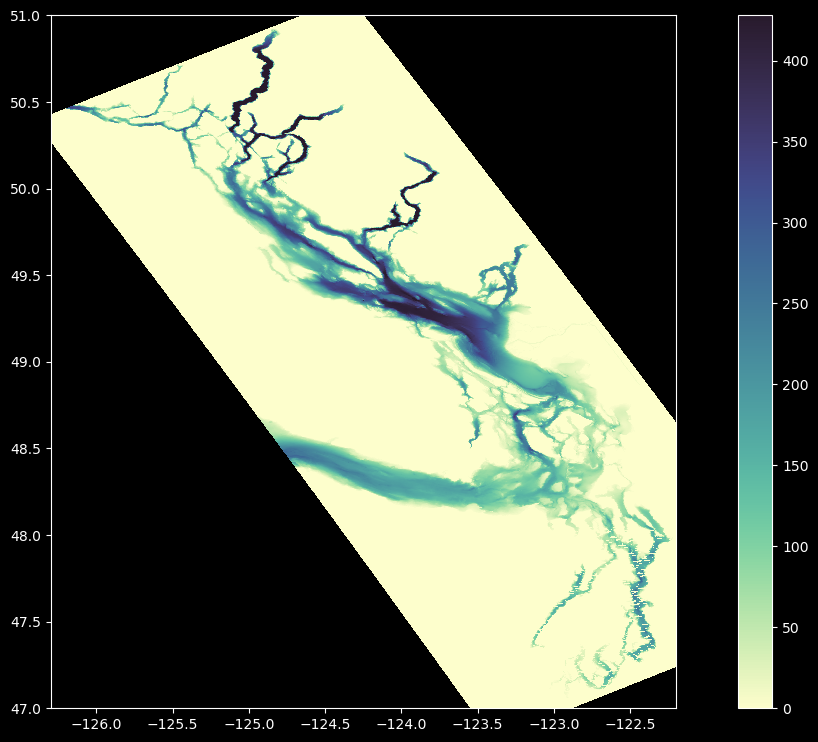

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lons_e, lats_e, base_bathy, cmap=cmap)
fig.colorbar(mesh, ax=ax);

In [9]:
def depth_check(bathy):
    """Checks the depth at each point of the bathymetric data and prints
    whether it is "Deep" or "Shallow".

    A depth greater than 428 is considered "Deep" and a depth between 0
    and 4 (non-inclusive) is considered "Shallow". The function iterates
    through the entire 2D array of bathymetric data to classify each point.

    :param bathy: 2D array of bathymetric data where each element represents
                  the depth at that point
    :type bathy: numpy.ndarray

    :return: None
    """
    DEEP_DEPTH_THRESHOLD = 428
    SHALLOW_DEPTH_UPPER_THRESHOLD = 4
    SHALLOW_DEPTH_LOWER_THRESHOLD = 0

    # Utility function to encapsulate repeating depth info printing
    def print_depth_info(mask, label, base_bathy):
        for y in mask.y:
            for x in mask.x:
                if mask[y, x]:
                    print(
                        f"{label}: y={y.item()}, x={x.item()}, depth={base_bathy[y, x].item()}"
                    )

    # Identify deep and shallow areas
    deep_mask = bathy > DEEP_DEPTH_THRESHOLD
    shallow_mask = numpy.logical_and(
        base_bathy < SHALLOW_DEPTH_UPPER_THRESHOLD,
        base_bathy > SHALLOW_DEPTH_LOWER_THRESHOLD
    )

    # Handle deep areas
    if deep_mask.any():
        print_depth_info(deep_mask, "Deep", base_bathy)

    # Handle shallow areas
    if shallow_mask.any():
        print_depth_info(shallow_mask, "Shallow", base_bathy)


In [10]:
depth_check(base_bathy)

## Straighten Channel at North Open Boundary

Change the shape of Johnstone Strait at the north boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

In [11]:
ns_bathy = base_bathy.copy()
js = 70  # x index to start changes at
je = 120  # x index to end changes at

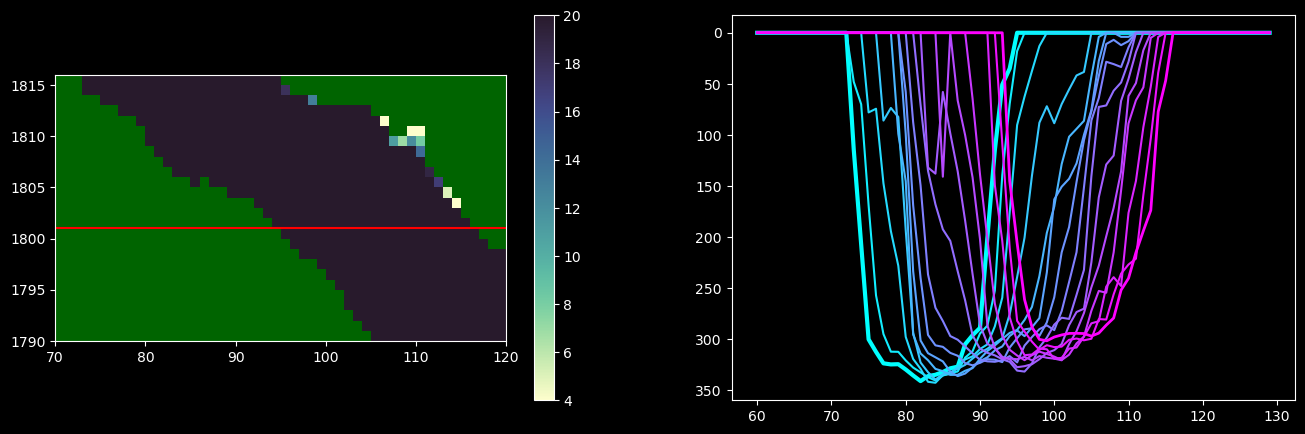

In [12]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)


def plot_north_bdy(ns_masked, y_max):
    fig, (ax_plan, ax_depth) = plt.subplots(1, 2, figsize=(16, 5))
    ax_plan.set_ylim((1790, y_max))
    ax_plan.set_xlim((70, 120))
    ax_plan.plot([70, 120], [y_max-15, y_max-15], 'r-')

    viz_tools.set_aspect(ax_plan)
    mesh = ax_plan.pcolormesh(ns_masked, cmap=cmap, vmax=20)
    fig.colorbar(mesh, ax=ax_plan)
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1, js - 10:je + 10],
                  color=scalarMap.to_rgba(0), linewidth=3)
    for i in range(1, 14):
        ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - i, js - 10:je + 10],
                      color=scalarMap.to_rgba(i))
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - 14, js - 10:je + 10],
                  color=scalarMap.to_rgba(14), linewidth=2)
    ax_depth.invert_yaxis()


plot_north_bdy(ns_masked, y_max)

In [13]:
# Take the nice smooth curve at the boundary and blend it into the nice smooth curve at 15 which is ss=21 steps west
# TOO perfect, so add in some of the variation in the real bathymetry (after keep)
init_north = np.array(base_bathy[y_max-1, :])
init_15 = np.array(base_bathy[y_max-15, :])
ss = 21
# first six rows are straight, shifted add to the east
add = 10
strat = 6
for ii in range(y_max-strat, y_max):
    ns_bathy[ii, js:je] = init_north[js-add:je-add]
# now blend into the bathymetry at 15 shifting 2 or 3 (average 2.4) east as we go
keep = strat+5
for ii in range(strat, keep):
    row = y_max - 1 - ii # row where we are putting the new bathymetry
    jj = ii - strat # weighting as we move down
    shift = int(jj*1.3) + add # how far we shift
    ns_bathy[row, js+shift:je+shift] = (((10-jj) * init_north[js:je] + jj * init_15[js+ss:je+ss]))/10.
for ii in range(keep, 15+1):
    row = y_max - 1 - ii # row where we are putting the new bathymetry
    jj = ii - strat # weighting as we move down
    shift = int(jj*1.3) + add # how far we shift
    ns_bathy[row, js+shift:je+shift] = np.maximum((((10-jj) * init_north[js:je] + jj * init_15[js+ss:je+ss]))/10., base_bathy[row, js+shift:je+shift])

10
11
12
13
15
16
17
19
20
21


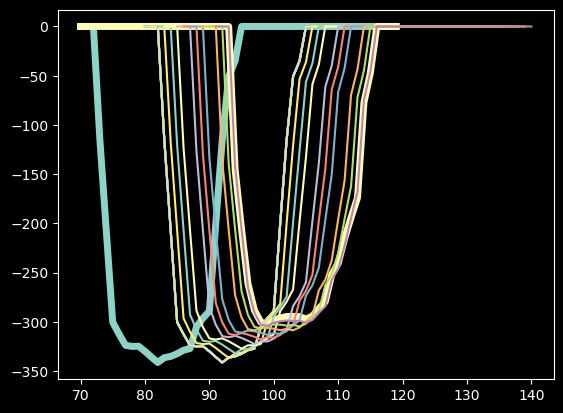

In [14]:
# Cell to perfect the shifting and blending
plt.plot(range(js, je), np.array(-base_bathy[y_max-1, js:je]), linewidth=5)
add = 10
strat = 6
ss = 21
plt.plot(range(js, je), np.array(-base_bathy[y_max-15, js:je]), linewidth=5)
for ii in range(strat):
    plt.plot(range(js+add, je+add), np.array(-base_bathy[y_max-1, js:je]))
for ii in range(strat, 15+1):
    jj = ii - strat
    shift = int(jj*1.3) + add
    print (shift)
    plt.plot(range(js+shift, je+shift), (((10-jj)*np.array(-base_bathy[y_max-1, js:je]) + jj*np.array(-base_bathy[y_max-15, js+ss:je+ss]))/10.))

In [15]:
# Remove shallow points, deepen points almost at 4
for i in range(1800,y_max):
    for j in range(70, 120) :
        if ns_bathy[i, j] < 2:
            ns_bathy[i, j] = 0
        elif ns_bathy[i, j] < 4:
            ns_bathy[i, j] = 4

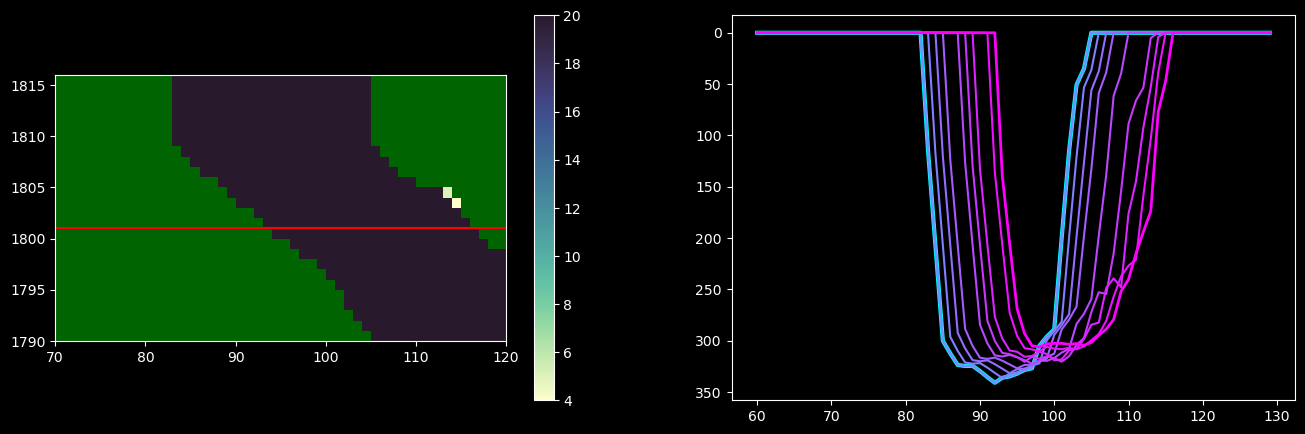

In [16]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)
plot_north_bdy(ns_masked, y_max)

depth_check(ns_masked)

## Straighten Channel at West Open Boundary

Change the shape of Jua de Fuca Strait at the west boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

In [17]:
ws_bathy = ns_bathy.copy()
iss = 350*2 + 10*2
iee = 470*2 + 10*2

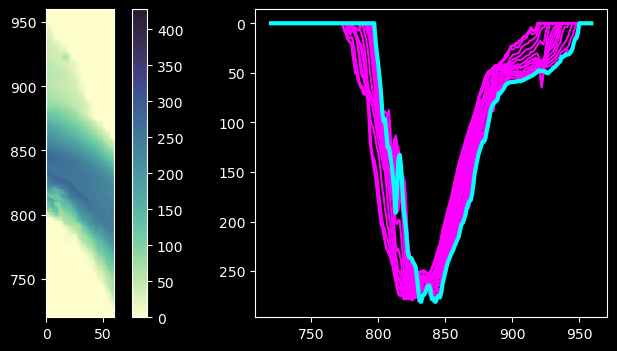

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_bathy, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((iss, iee))
axs[0].set_xlim((0, 30*2));

for j in range(1, 14*2, 2):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14*2], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()

Unlike the North, the mouth profile is kind of jagged.
A. We'll take out the bank to the south by rearranging the profile and
B. We'll rearrange the depths in the centre, so that they are a simple up and down: i.e. make the two deep channels into one. At the same time, move the deepest point, one point to the south. This emphasizes the southern channel, which is the channel that continues into Juan de Fuca. We do this so there is no artifical sill in this channel which is not seen in the original bathymetry.

[110.70277659 125.09666443 125.26741664 132.94555664 143.28166707
 155.54082743 169.2851944  191.03959147 169.50092061 137.13750203
 132.64415995 144.13612366 166.79582214 188.32392629 198.86112722
 211.51165517 231.05262756 236.2228953  236.28281148 237.30971018]


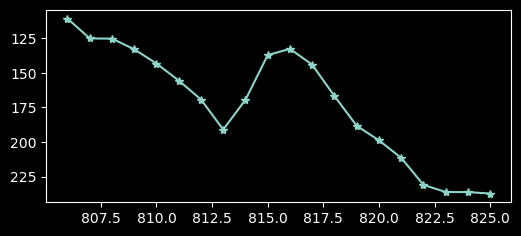

In [19]:
core = np.copy(ws_bathy[:, 0])
print (core[iss+43*2:iss+53*2])
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iss+43*2, iss+53*2), ws_bathy[iss+43*2:iss+53*2, 0], '-*')
ax.invert_yaxis();

[110.70277659 125.09666443 125.26741664 132.64415995 132.94555664
 137.13750203 143.28166707 144.13612366 155.54082743 166.79582214
 169.2851944  169.50092061 188.32392629 191.03959147 198.86112722
 211.51165517 231.05262756 236.2228953  236.28281148 237.30971018]


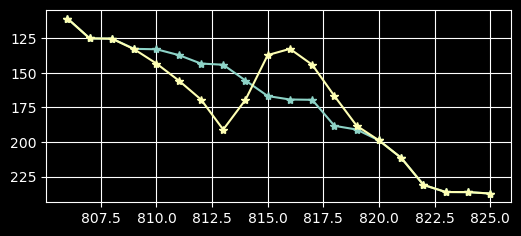

In [20]:
# A. remove bank
core[809] = ws_bathy[816, 0]
core[810] = ws_bathy[809, 0]
core[811] = ws_bathy[815, 0]
core[812] = ws_bathy[810, 0]
core[813] = ws_bathy[817, 0]
core[814] = ws_bathy[811, 0]
core[815] = ws_bathy[818, 0]
core[816] = ws_bathy[812, 0]
core[817] = ws_bathy[814, 0]
core[818] = ws_bathy[819, 0]
core[819] = ws_bathy[813, 0]
print (core[iss+43*2:iss+53*2])
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iss+43*2, iss+53*2), core[iss+43*2:iss+53*2], '*-')
ax.plot(np.arange(iss+43*2, iss+53*2), ws_bathy[iss+43*2:iss+53*2, 0], '-*')
ax.invert_yaxis();
ax.grid()

[236.28281148 237.30971018 240.93969727 242.94869995 246.28077952
 257.44332886 270.63043213 279.88183594 280.97012838 275.39338684
 274.03349304 272.16280111 268.12557983 264.75882467 264.37724813
 268.90191142 278.21409607 277.29577128 280.6583964  280.66595459
 276.80905151 274.74803162 276.52190653 272.08627319 263.05193075
 257.26968892 251.01481883 245.70648448 240.70204163 237.67063904]


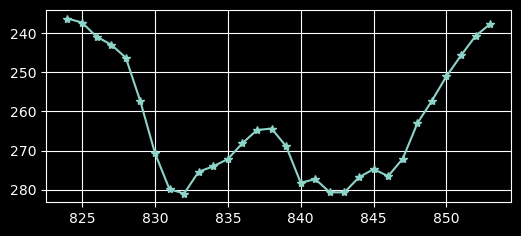

In [21]:
nis, nie = 402*2+20, 417*2+20
print (ws_bathy[nis:nie, 0].values)
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(nis, nie), ws_bathy[nis:nie, 0], '-*')
ax.invert_yaxis();
ax.grid();

[236.28281148 237.30971018 240.93969727 242.94869995 246.28077952
 257.44332886 270.63043213 280.97012838 280.66595459 280.6583964
 279.88183594 278.21409607 277.29577128 276.80905151 276.52190653
 275.39338684 274.74803162 274.03349304 272.16280111 272.08627319
 268.90191142 268.12557983 264.75882467 264.37724813 263.05193075
 257.26968892 251.01481883 245.70648448 240.70204163 237.67063904]


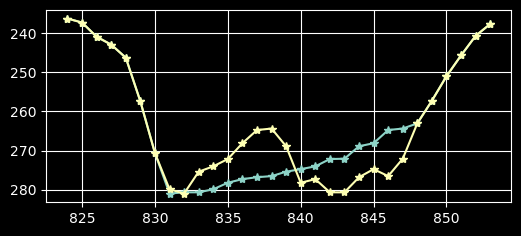

In [22]:
# B. Fix central channel
core[831] = ws_bathy[832, 0] #280.97
core[832] = ws_bathy[843, 0] #280.666
core[833] = ws_bathy[842, 0] #280.658
core[834] = ws_bathy[831, 0] #279.88
core[835] = ws_bathy[840, 0] #278.21
core[836] = ws_bathy[841, 0] #277.3
core[837] = ws_bathy[844, 0] #276.8
core[838] = ws_bathy[846, 0] #276.5
core[839] = ws_bathy[833, 0] #275.4
core[840] = ws_bathy[845, 0] #274.7
core[841] = ws_bathy[834, 0] #274.0
core[842] = ws_bathy[835, 0] #272.2
core[843] = ws_bathy[847, 0] #272.1
core[844] = ws_bathy[839, 0] #268.9
core[845] = ws_bathy[836, 0] #268.1
core[846] = ws_bathy[837, 0] #264.7
core[847] = ws_bathy[838, 0] #264.4
print (core[nis:nie])
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(nis, nie), core[nis:nie], '*-')
ax.plot(np.arange(nis, nie), ws_bathy[nis:nie, 0], '-*')
ax.invert_yaxis();
ax.grid()

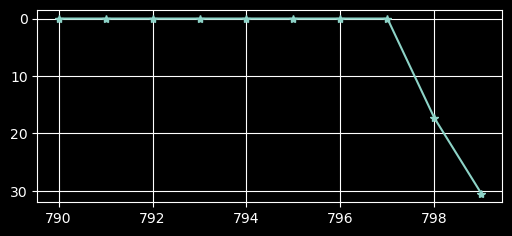

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iss+70, iss+80), core[iss+70:iss+80], '*-')
ax.invert_yaxis();
ax.grid()
# Non-zero starts at 798

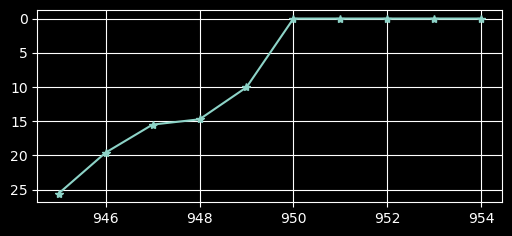

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iee-15, iee-5), core[iee-15:iee-5], '*-')
ax.invert_yaxis();
ax.grid()
# Non-zero starts at 949

In [25]:
nosmooth = core.copy()

In [26]:
# smooth the west profile, twice
newcore = core
for i in range(iss, iee):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
for i in range(iss, iee):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
# rezero south part so we do not expand the domain
core[0:798] = 0
# rezero north part so we do not expand the domain
core[950:] = 0

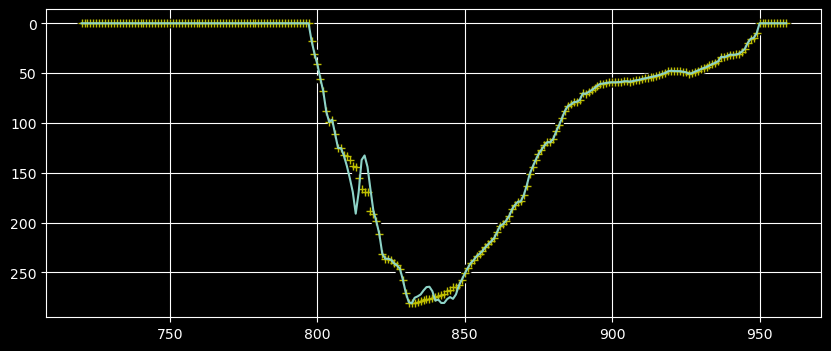

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(range(iss, iee), core[iss:iee],'ko')
ax.plot(range(iss, iee), nosmooth[iss:iee],'y+')
ax.plot(range(iss, iee), ws_bathy[iss:iee, 0],'-')
ax.invert_yaxis();
#ax.set_xlim(800, 850)
ax.grid()

We now have "core" which is the bathymetry at the mouth. This continues 5 more grid points into the domain. Beyond that we blend into the original bathymetry linearly over the next 10 grid points. The only difficulty is that we need to follow the bathymetry south-east, so we need to shift south as we go.

In [28]:
for i in range(0,5):
    ws_bathy[iss:iee, i] = core[iss:iee]
i = 5
ws_bathy[iss:iee, i] = (-i+15)/10.*core[iss:iee] + (i-5)/10.*ws_bathy[iss:iee, i]
i = 6
sh = 1
ws_bathy[iss:iee, i] = (-i+15)/10.*(core[iss:iee]+core[iss+sh:iee+sh])/2. + (i-5)/10.*ws_bathy[iss:iee, i]
i = 7
ws_bathy[iss:iee, i] = (-i+15)/10.*core[iss+sh:iee+sh] + (i-5)/10.*ws_bathy[iss:iee, i]
i = 8
sh2 = 2
ws_bathy[iss:iee, i] = (-i+15)/10.*(core[iss+sh:iee+sh]+core[iss+sh2:iee+sh2])/2. + (i-5)/10.*ws_bathy[iss:iee, i]
i = 9
sh = 2
ws_bathy[iss:iee, i] = (-i+15)/10.*core[iss+sh:iee+sh] + (i-5)/10.*ws_bathy[iss:iee, i]
i = 10
sh2 = 3
ws_bathy[iss:iee, i] = (-i+15)/10.*(core[iss+sh:iee+sh]+core[iss+sh2:iee+sh2])/2. + (i-5)/10.*ws_bathy[iss:iee, i]
i = 11
sh = 3
ws_bathy[iss:iee, i] = (-i+15)/10.*core[iss+sh:iee+sh] + (i-5)/10.*ws_bathy[iss:iee, i]
i = 12
sh2 = 4
ws_bathy[iss:iee, i] = (-i+15)/10.*(core[iss+sh:iee+sh]+core[iss+sh2:iee+sh2])/2. + (i-5)/10.*ws_bathy[iss:iee, i]
i = 13
sh = 4
ws_bathy[iss:iee, i] = (-i+15)/10.*core[iss+sh:iee+sh] + (i-5)/10.*ws_bathy[iss:iee, i]
i = 14
shs = 5
ws_bathy[iss:iee, i] = (-i+15)/10.*(core[iss+sh:iee+sh]+core[iss+sh2:iee+sh2])/2. + (i-5)/10.*ws_bathy[iss:iee, i]

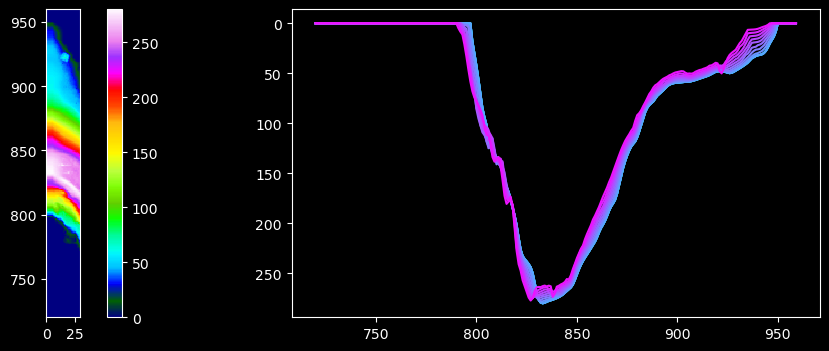

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_bathy, cmap='gist_ncar', vmax=280)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((iss, iee))
axs[0].set_xlim((0, 30));

for j in range(1, 14, 1):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(j))
#axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
#axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()

## Adjust Specific Grid Cells

Adjust the depth of specific grid cells based on the tile by tile comparisons in the `Compare202405-2xrezBathymetry.ipynb` notebook.

The "Tile y, x" titles in this section match those in the comparison notebook.

In [30]:
adj_bathy = np.ma.masked_array(ws_bathy, ws_bathy == 0)

depth_check(adj_bathy)

In [31]:
# use single resolution index values because they are more familiar
tile_x_min_max = [
    numpy.array([0, 35]),
    numpy.array([30, 65]),
    numpy.array([60, 95]),
    numpy.array([90, 125]),
    numpy.array([120, 155]),
    numpy.array([150, 185]),
    numpy.array([180, 215]),
    numpy.array([210, 245]),
    numpy.array([240, 275]),
    numpy.array([270, 305]),
    numpy.array([300, 335]),
    numpy.array([330, 365]),
    numpy.array([360, 398]),
]

In [32]:
def to_array_indices(adj_pt, y_min_max, x_min_max):
    dx, dy = adj_pt
    return y_min_max[0] * 2 + dy, x_min_max[0] * 2 + dx

### Row 9 - Juan de Fuca Strait to Bellingham Bay

In [33]:
y_min_max = numpy.array([300, 330])
y_slice = slice(*y_min_max * 2)

#### Tile 9, 5 - Metchosin

* connect island that is really end of William Head

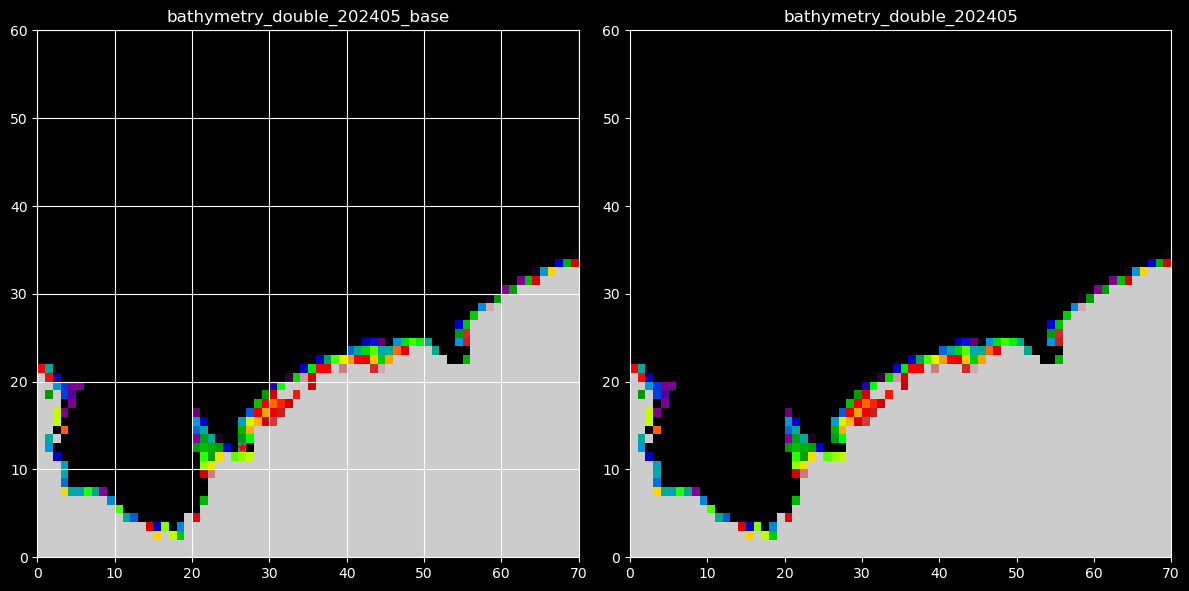

In [34]:
x_min_max = tile_x_min_max[5]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pt = numpy.array([26, 12])  # grid cell x-y to adjust in plot coordinates
ax_base.plot(*adj_pt+0.5, "r*")
# Do adjustment
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 9, 6 - Esquimalt and Victoria

* connect islands to make Esquimalt Point
* surface Chain Islands

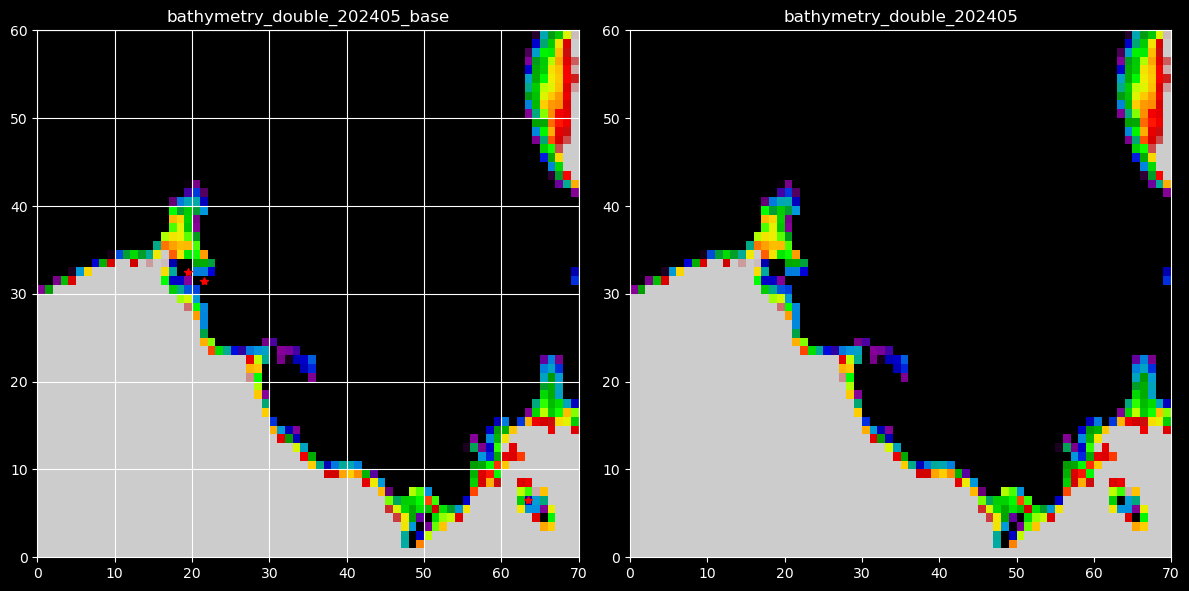

In [35]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([19, 32]),
    numpy.array([21, 31]),
    numpy.array([63, 6]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")
# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 9, 7 - Haro Strait

* fix Discovery Island
* Make east Chatham Island T-shaped

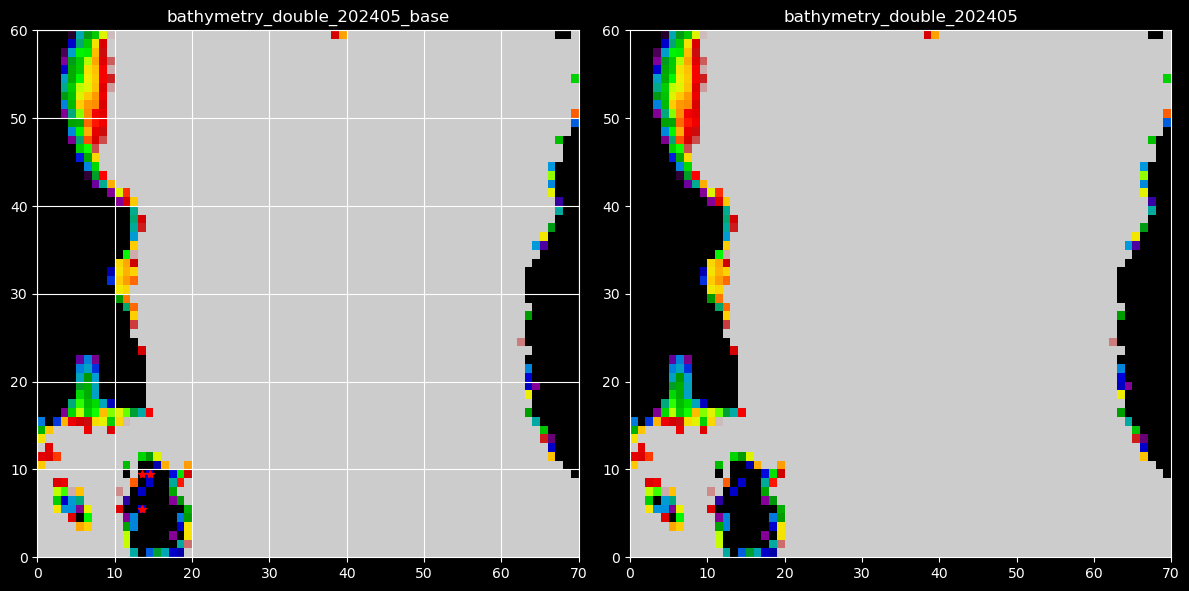

In [36]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([13, 5]),
    numpy.array([13, 9]),
    numpy.array([14, 9]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")
# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 10 - Juan de Fuca, Jordan River, Saanich Inlet, boundary islands, Neptune Beach

In [37]:
y_min_max = numpy.array([330, 360])
y_slice = slice(*y_min_max * 2)

#### Tile 10, 3 - Jordan River, French Beach, and Sheringham Point

* Remove extraneous island off French Beach

11.940832455952963
4.616666714350383
4.0
4.0
4.0
4.0
4.0
6.8121209144592285
5.421202510595322


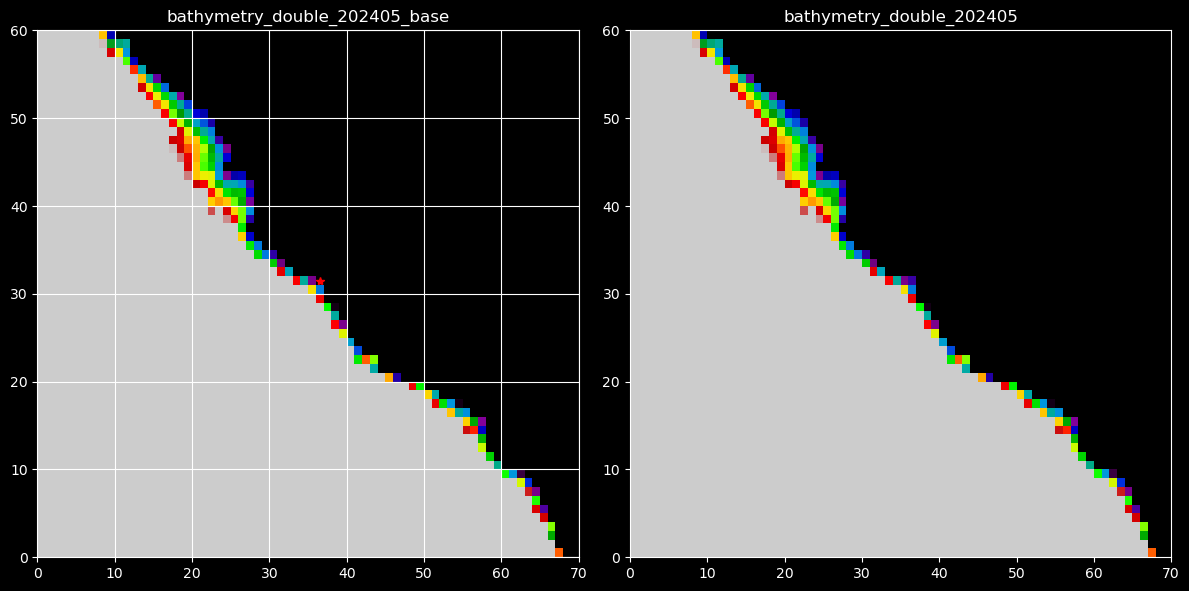

In [38]:
x_min_max = tile_x_min_max[3]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([36, 31]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([35, 30]),
    numpy.array([35, 31]),
    numpy.array([35, 32]),
    numpy.array([36, 32]),
    numpy.array([37, 32]),
    numpy.array([37, 31]),
    numpy.array([37, 30]),
    numpy.array([36, 30]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 10, 7 - James Island & Sidney Island

* connect spit on north end of Sidney Island
* connect Gooch Island
* Surface Forrest, Demville & Brethour Islands

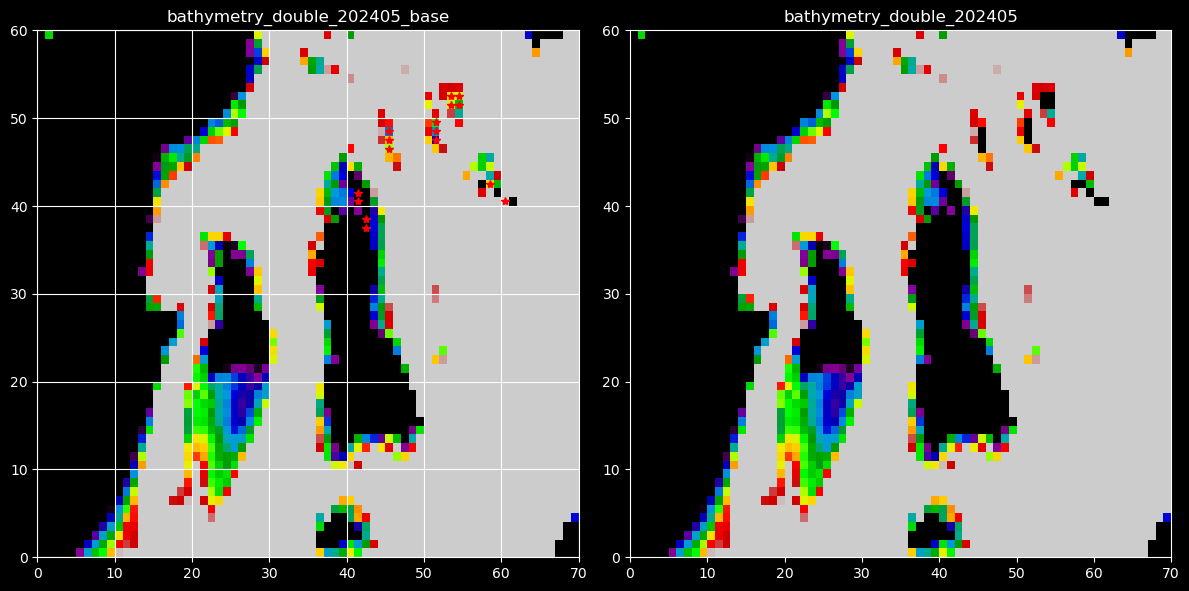

In [39]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Sidney Island spit
    numpy.array([42, 37]),
    numpy.array([42, 38]),
    numpy.array([41, 40]),
    numpy.array([41, 41]),
    # Gooch Island
    numpy.array([58, 42]),
    numpy.array([60, 40]),
    # Forrest Island
    numpy.array([45, 48]),
    numpy.array([45, 47]),
    numpy.array([45, 46]),
    # Forrest Island
    numpy.array([51, 49]),
    numpy.array([51, 48]),
    numpy.array([51, 47]),
    # Brethor Island
    numpy.array([53, 52]),
    numpy.array([53, 51]),
    numpy.array([54, 52]),
    numpy.array([54, 51]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 10, 9 - Waldron Island

* surface Skipjack Island

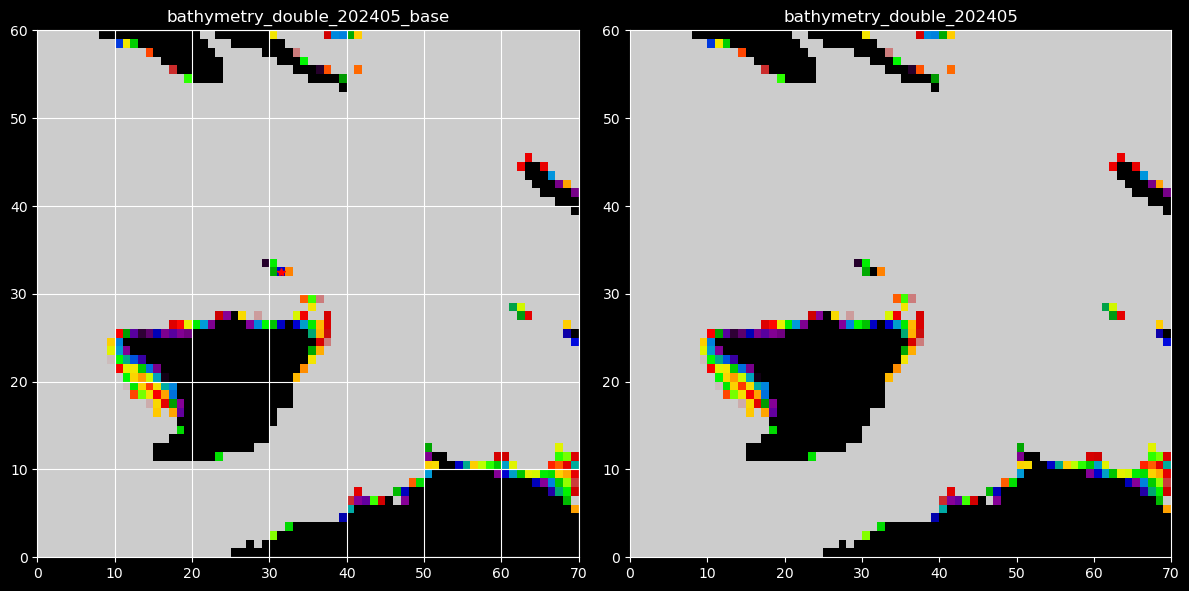

In [40]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([31, 32]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 11 - Neah Bay to Semiahmoo Bay

In [41]:
y_min_max = numpy.array([360, 390])
y_slice = slice(*y_min_max * 2)

#### Tile 11, 7 - Fulford Harbour

* surface Piers Island, Knapp Island & Pym Island

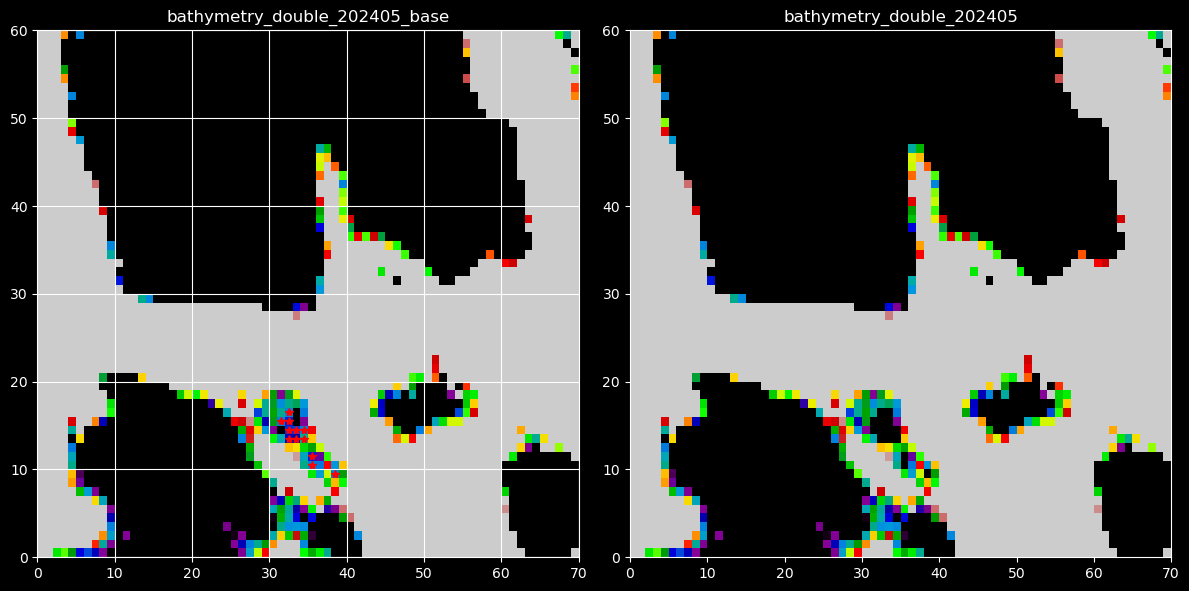

In [42]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Piers Island
    numpy.array([31, 15]),
    numpy.array([32, 16]),
    numpy.array([32, 15]),
    numpy.array([32, 14]),
    numpy.array([32, 13]),
    numpy.array([33, 14]),
    numpy.array([33, 13]),
    numpy.array([34, 14]),
    numpy.array([34, 13]),
    # Knapp Island
    numpy.array([35, 10]),
    numpy.array([35, 11]),
    # Pym Island
    numpy.array([38, 9]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 11, 9 - Saturna Island & Tumbo Island

* surface Tumbo Island
* narrow Boat Passage
* open west entrance to Winter Cove

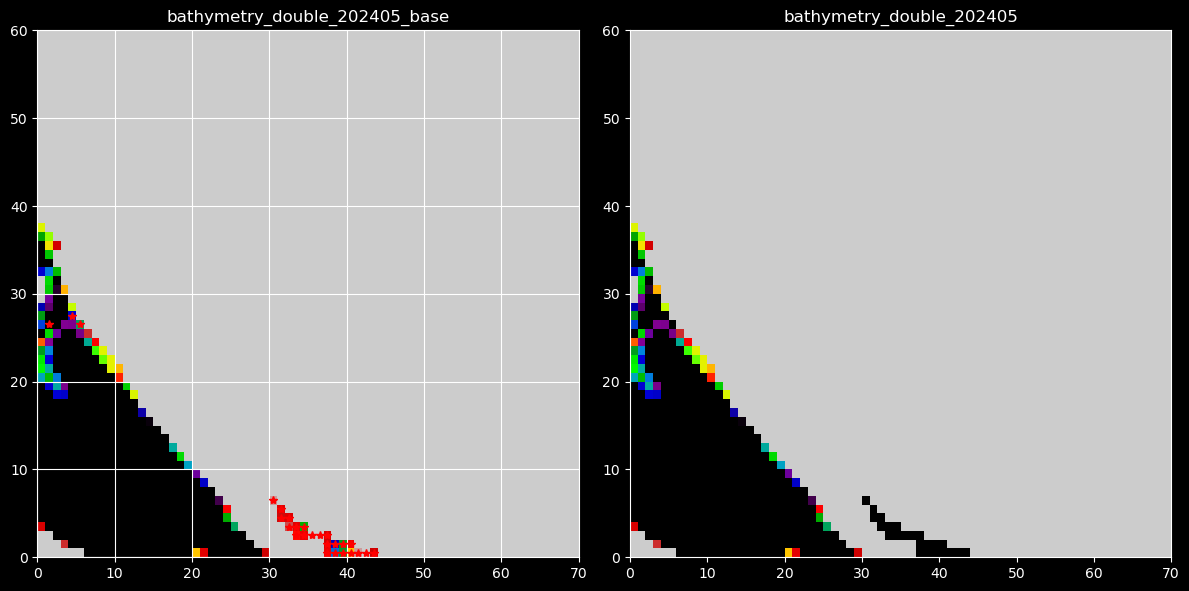

In [43]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Tumbo Island
    numpy.array([30, 6]),
    numpy.array([31, 5]),
    numpy.array([31, 4]),
    numpy.array([32, 4]),
    numpy.array([32, 3]),
    numpy.array([33, 3]),
    numpy.array([33, 2]),
    numpy.array([34, 3]),
    numpy.array([34, 2]),
    numpy.array([35, 2]),
    numpy.array([37, 2]),
    numpy.array([37, 0]),
    numpy.array([37, 1]),
    numpy.array([36, 2]),
    numpy.array([38, 0]),
    numpy.array([38, 1]),
    numpy.array([39, 0]),
    numpy.array([39, 1]),
    numpy.array([40, 0]),
    numpy.array([40, 1]),
    numpy.array([41, 0]),
    numpy.array([42, 0]),
    numpy.array([43, 0]),
    # north side of Boat Passage
    numpy.array([4, 27]),
    numpy.array([5, 26]),
    # west entrance to Winter Cove
    numpy.array([1, 26]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts[:-1]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan
adj = to_array_indices(adj_pts[-1], y_min_max, x_min_max)
adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 12 - Neah Bay to Surrey

In [44]:
y_min_max = numpy.array([390, 420])
y_slice = slice(*y_min_max * 2)

#### Tile 12, 7 - Crofton, Ganges, Long Harbour & Trincomali Channel

* fill in Athol Peninsula

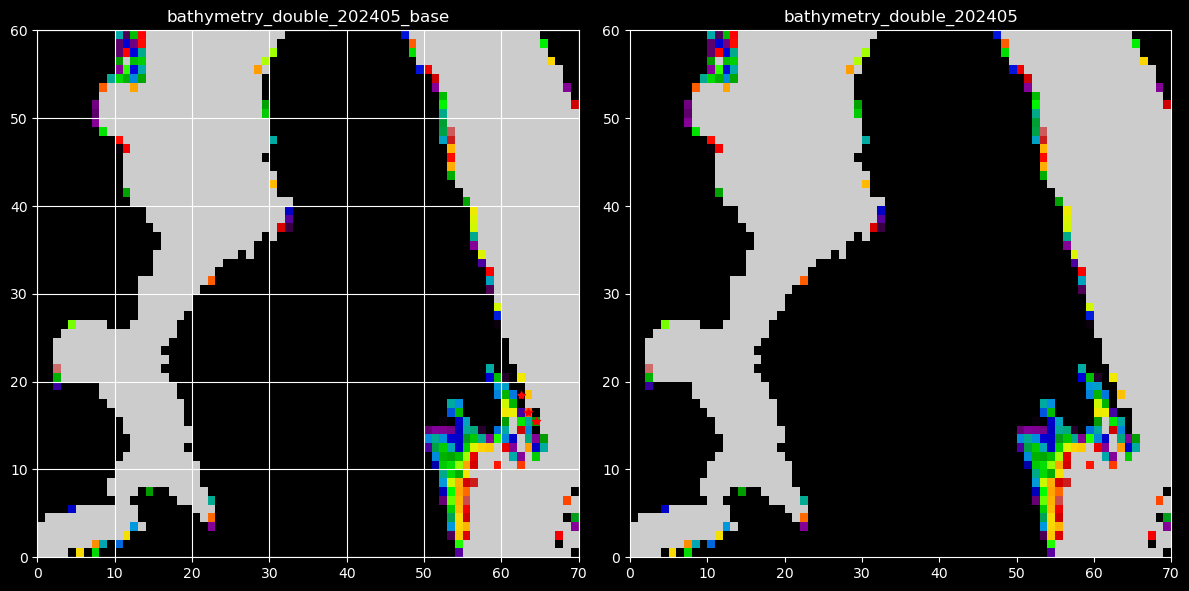

In [45]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([62, 18]),
    numpy.array([63, 16]),
    numpy.array([64, 15]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 12, 8 - Galiano Island

* separate Parker Island
* connect 2 points on north end of Prevost Island

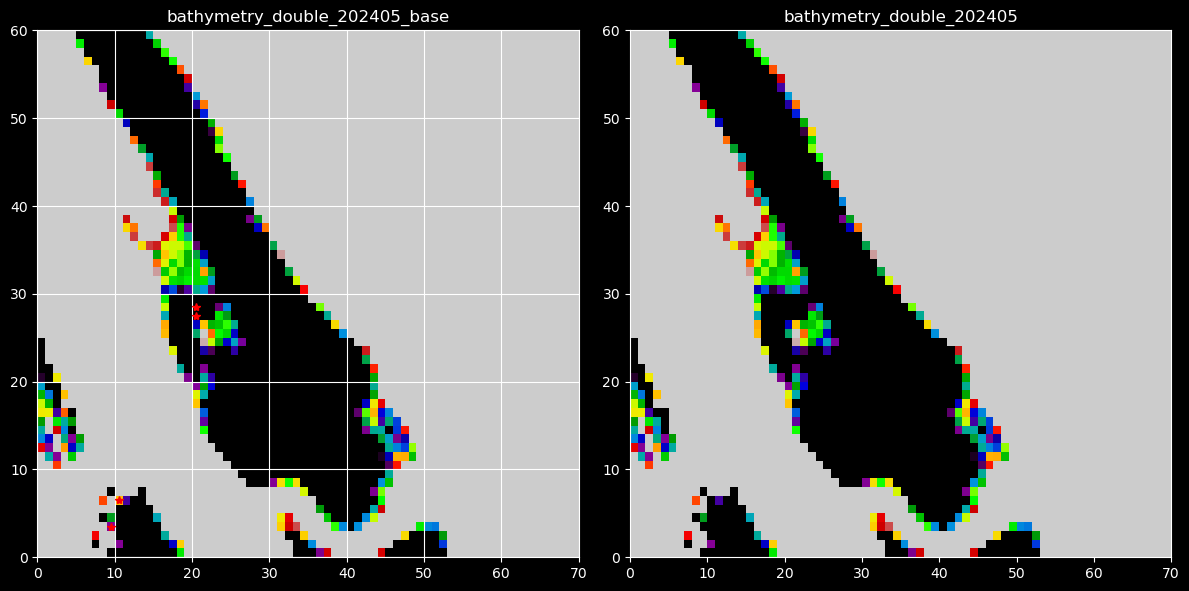

In [46]:
x_min_max = tile_x_min_max[8]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Parker Island separation
    numpy.array([20, 28]),
    numpy.array([20, 27]),
    # north Prevost Island points
    numpy.array([10, 6]),
    numpy.array([9, 3]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts[:2]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4
for adj_pt in adj_pts[-2:]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 12, 9 - Roberts Bank

* change 4 fake islands to 4m deep

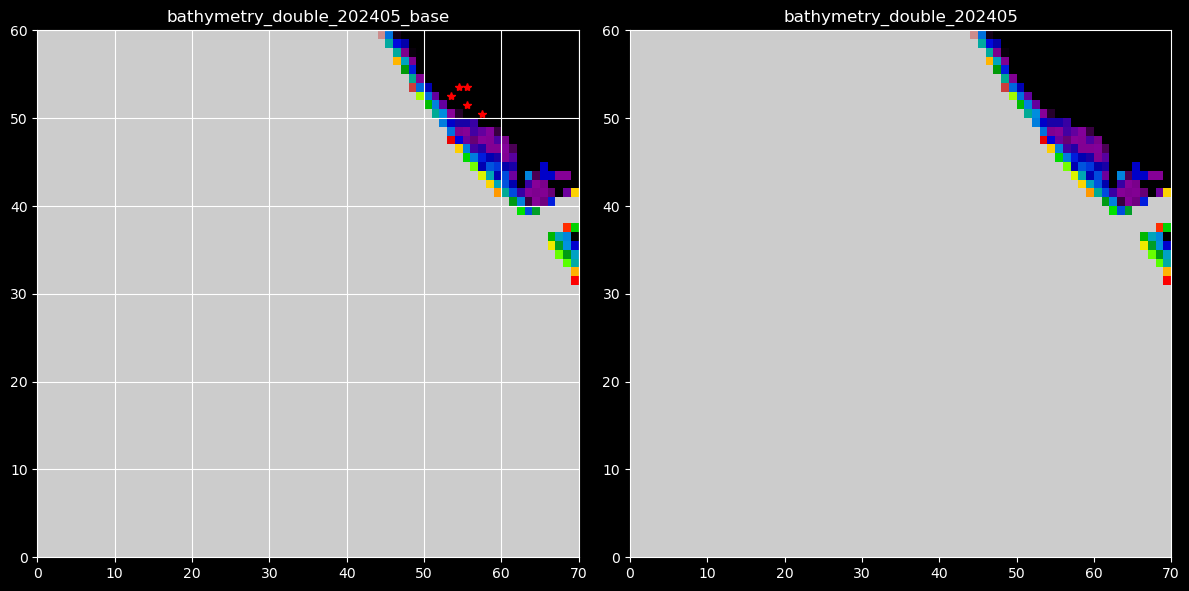

In [47]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([53, 52]),
    numpy.array([54, 53]),
    numpy.array([55, 53]),
    numpy.array([55, 51]),
    numpy.array([57, 50]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 12, 10 - Point Roberts & Tsawwassen

* add Tsawwassen ferry terminal and spit
* add Roberts Bank port and spit
* change fake island SE of Pt. Roberts to 4m deep

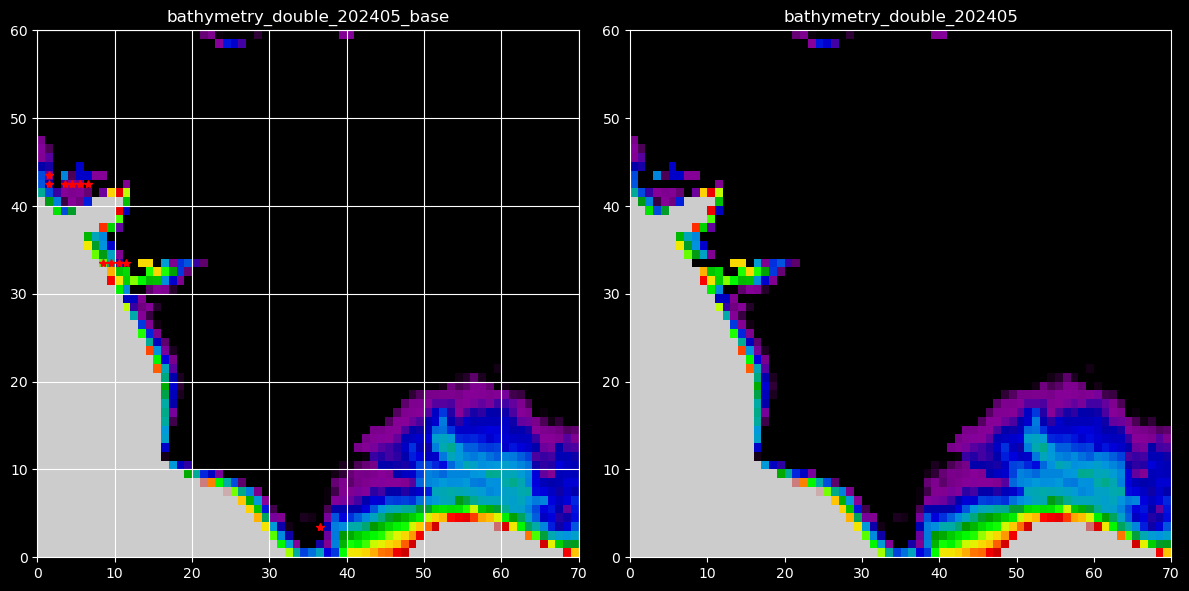

In [48]:
x_min_max = tile_x_min_max[10]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Tsawwassen ferry terminal and spit
    numpy.array([11, 33]),
    numpy.array([10, 33]),
    numpy.array([9, 33]),
    numpy.array([8, 33]),
    # Roberts Bank port and spit
    numpy.array([1, 43]),
    numpy.array([1, 42]),
    numpy.array([3, 42]),
    numpy.array([4, 42]),
    numpy.array([5, 42]),
    numpy.array([6, 42]),
    # fake island SE of Pt. Roberts
    numpy.array([36, 3]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts[:-1]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan
adj = to_array_indices(adj_pts[-1], y_min_max, x_min_max)
adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 13 - Carmanah Point to Fraser River

In [49]:
y_min_max = numpy.array([420, 450])
y_slice = slice(*y_min_max * 2)

#### Tile 13, 6 - Stz’Uminus, Saltair & Chemainus

* connect Bare Point opposite Chemainus

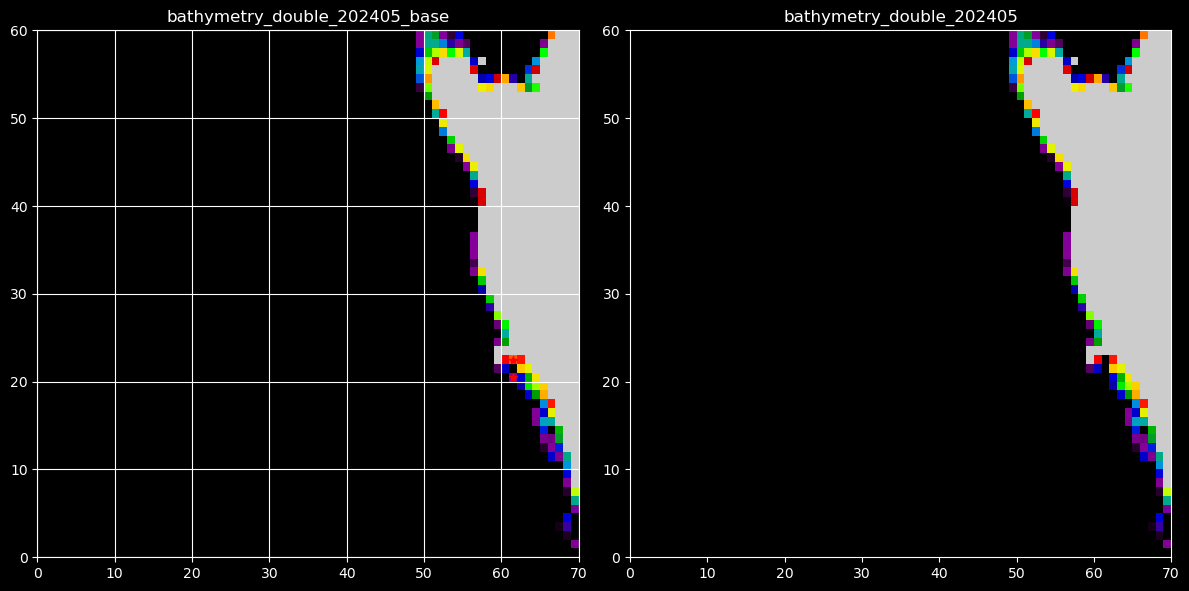

In [50]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([61, 20]),
    numpy.array([61, 22]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 13, 7 - Thetis & Penelakut Islands, Valdes Island, North Galiano Island

* assign average depths to 1 fake island and fake point on west shore of Thetis Island
* connect south point of Wallace Island
* surface Hall Island
* surface Norway Island
* fix Reid Island and remove north islets


19.564618428548176
9.385672569274902
7.791589736938477
19.0
5.0
4.0
4.0
15.0
10.467735091845194
5.0
4.0
11.0
4.0
4.109372178713481
6.743993282318115
9.0
9.0
6.60667068262895
15.770833492279053
15.878101666768393
32.0
13.0
14.0
7.0
16.0
15.0
16.08111689488093
32.0
30.0
38.0747013092041
7.0
10.0
24.0
16.0
22.439243044172013
29.38249142964681
24.0
11.080454667409262
10.0
18.615736524264015


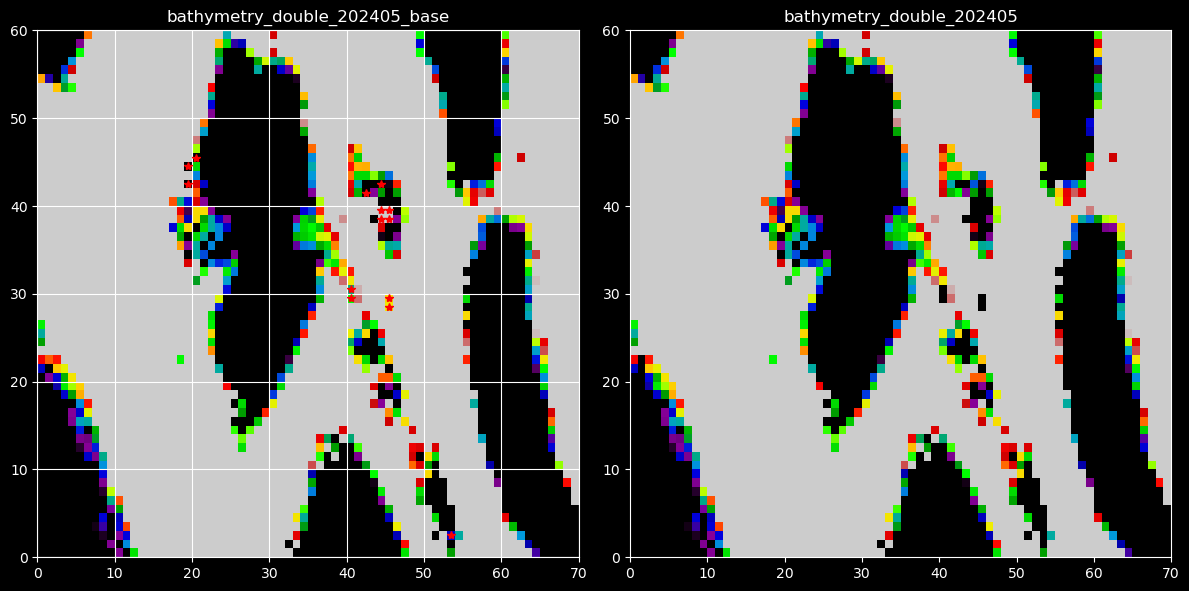

In [51]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    # connect south point of Wallace Island
    numpy.array([53, 2]),
    # surface Hall Island
    numpy.array([45, 29]),
    numpy.array([45, 28]),
    # surface Norway Island
    numpy.array([40, 29]),
    numpy.array([40, 30]),
    # fix Reid Island
    numpy.array([44, 39]),
    numpy.array([45, 39]),
    numpy.array([44, 38]),
    numpy.array([45, 38]),
]
water_pts = [  # grid cell x-y to adjust in plot coordinates
    # fake island and fake point on west shore of Thetis Island
    numpy.array([19, 42]),
    numpy.array([19, 44]),
    numpy.array([20, 45]),
    # fake islets north of Reid Island
    numpy.array([44, 42]),
    numpy.array([42, 41]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")

# Do adjustment
for land_pt in land_pts:
    land = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[land] = np.nan
# fake islet north-west of Reid Island
adj_pt = numpy.array([42, 41])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([41, 40]),
    numpy.array([41, 41]),
    numpy.array([41, 42]),
    numpy.array([43, 40]),
    numpy.array([43, 41]),
    numpy.array([43, 42]),
    numpy.array([42, 42]),
    numpy.array([42, 40]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

# fake islet north of Reid Island
adj_pt = numpy.array([44, 42])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([43, 41]),
    numpy.array([43, 42]),
    numpy.array([43, 43]),
    numpy.array([45, 41]),
    numpy.array([45, 42]),
    numpy.array([45, 43]),
    numpy.array([44, 43]),
    numpy.array([44, 41]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

# fake islet west of Thetis Island
adj_pt = numpy.array([19, 42])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([18, 41]),
    numpy.array([18, 42]),
    numpy.array([18, 43]),
    numpy.array([20, 41]),
    numpy.array([20, 42]),
    numpy.array([20, 43]),
    numpy.array([19, 43]),
    numpy.array([19, 41]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

# fake point on west shore of Thetis Island
adj_pt = numpy.array([19, 44])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([18, 43]),
    numpy.array([18, 44]),
    numpy.array([18, 45]),
    numpy.array([20, 43]),
    numpy.array([20, 44]),
    # numpy.array([20, 45]),  # land
    numpy.array([19, 45]),
    numpy.array([19, 43]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean
adj_pt = numpy.array([20, 45])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([19, 46]),
    numpy.array([19, 45]),
    # numpy.array([19, 44]),  # land
    # numpy.array([21, 46]),  # land
    # numpy.array([21, 45]),  # land
    # numpy.array([21, 44]),  # land
    numpy.array([20, 46]),
    numpy.array([20, 44]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 13, 9 - Fraser River Main Channel, Westham Island, Steveston

* little pixel islands are okay, as long as water can go everywhere
* add a final point to Steveston Jetty (change to 4m deep)
* make southern channel of Fraser River contiguous (change 1 cell to to 4m deep)


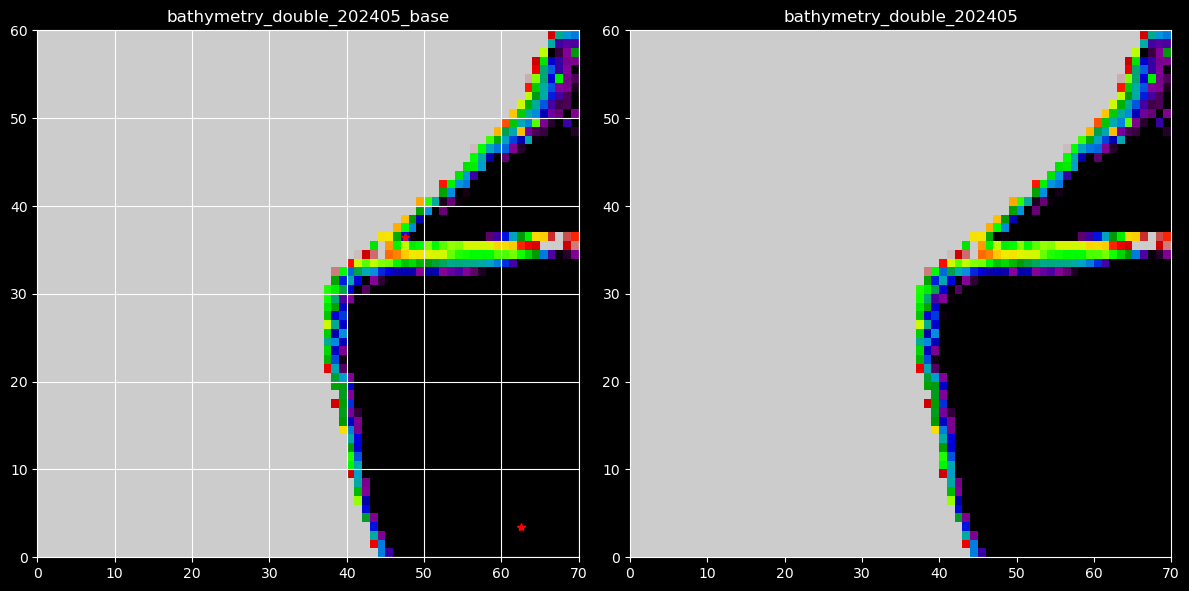

In [52]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([47, 36]),
    numpy.array([62, 3]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 13, 10 - Richmond, Delta, Deas Island, Fraser River Middle Arm

* leave pixel islands on Lulu Island foreshore mud flats
* Canoe Pass is fine
* open Fraser River Middle Arm

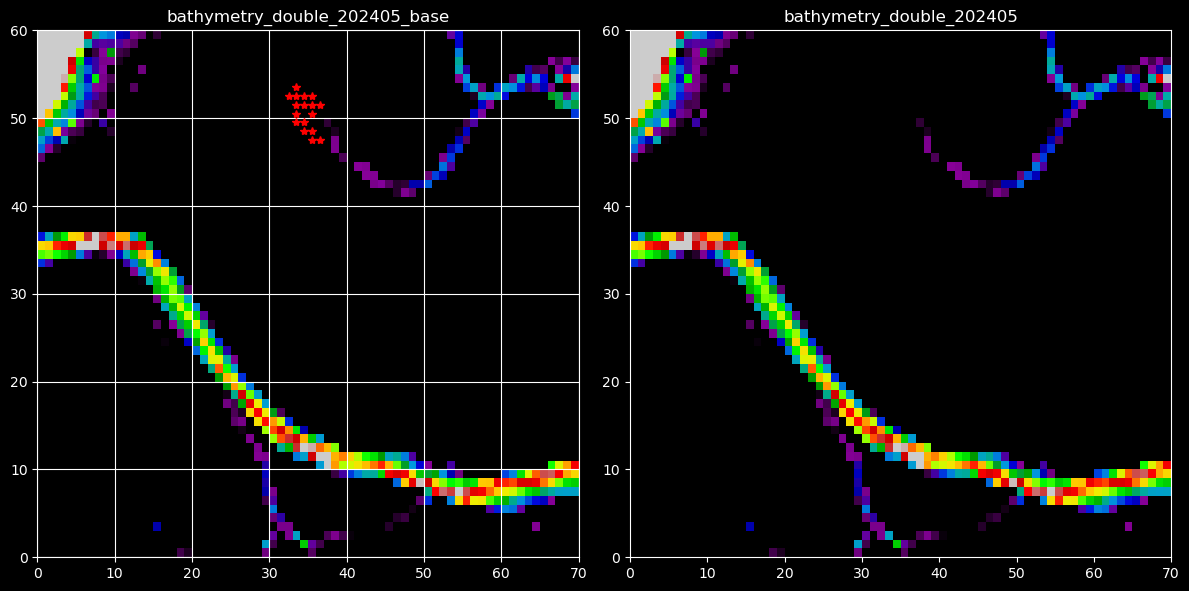

In [53]:
x_min_max = tile_x_min_max[10]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([33, 53]),
    numpy.array([32, 52]),
    numpy.array([33, 52]),
    numpy.array([34, 52]),
    numpy.array([35, 52]),
    numpy.array([33, 51]),
    numpy.array([34, 51]),
    numpy.array([35, 51]),
    numpy.array([36, 51]),
    numpy.array([33, 50]),
    # numpy.array([34, 50]),  # Swishwash Island
    numpy.array([35, 50]),
    numpy.array([33, 49]),
    numpy.array([34, 49]),
    # numpy.array([35, 49]),  # Swishwash Island
    numpy.array([34, 48]),
    numpy.array([35, 48]),
    # numpy.array([36, 48]),  # Swishwash Island
    numpy.array([35, 47]),
    numpy.array([36, 47]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 13, 11 - Queensborough, Annacis Island, Fraser River Split

* surface Mitchell Island: very weird, the current land point is the in middle of the deep channel (gray), Mitchell Island is north of the channel
* connect west tip of Annacis Island

* (note, bend into Row 12 is fine)

8.629790849673203
4.0
7.902592182159424
7.886812244385712
5.151169540405274
40.82333755493164
4.8452671961705445
13.604583740234375
11.60544416349502


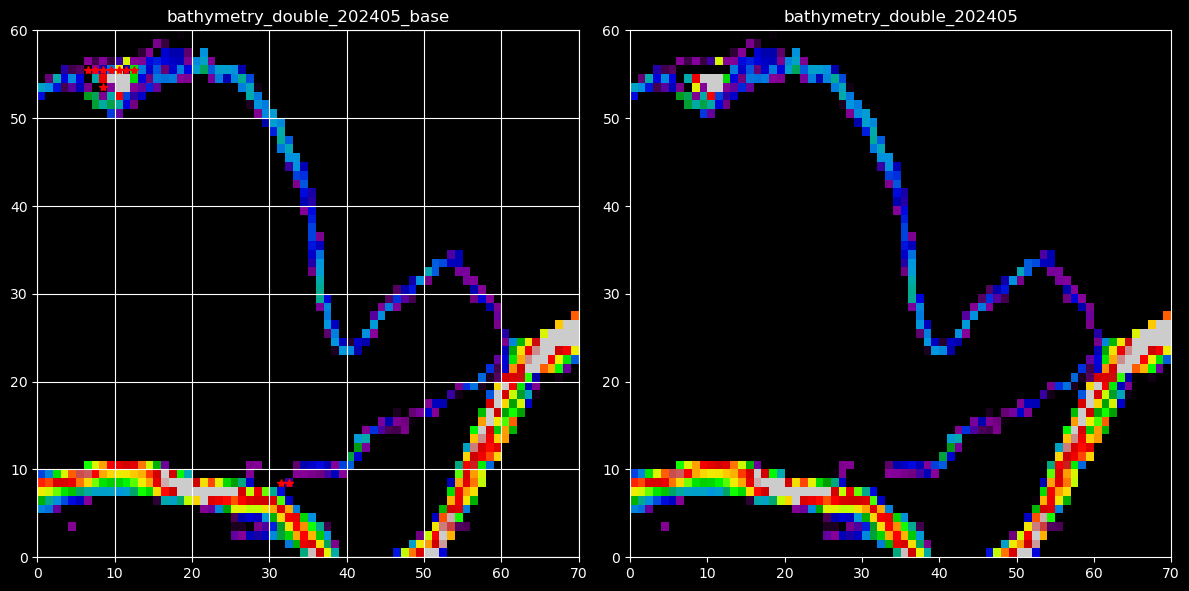

In [54]:
x_min_max = tile_x_min_max[11]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    # Mitchell Island
    numpy.array([6, 55]),
    numpy.array([7, 55]),
    numpy.array([8, 55]),
    numpy.array([9, 55]),
    numpy.array([10, 55]),
    numpy.array([11, 55]),
    numpy.array([12, 55]),
    # West tip of Annacis Island
    numpy.array([31, 8]),
    numpy.array([32, 8]),
]
water_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([8, 53]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")

# Do adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

# land cell that should be water south of Mitchell Island
adj_pt = numpy.array([8, 53])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([7, 52]),
    numpy.array([7, 53]),
    numpy.array([7, 54]),
    numpy.array([9, 52]),
    numpy.array([9, 53]),
    numpy.array([9, 54]),
    numpy.array([8, 52]),
    numpy.array([8, 54]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 14 - Tsusiat Point to English Bay

In [55]:
y_min_max = numpy.array([450, 480])
y_slice = slice(*y_min_max * 2)

#### Tile 14, 7 - Yellow Point, North Valdes Island, South Gabriola Island

* surface islands off Gabriola Island

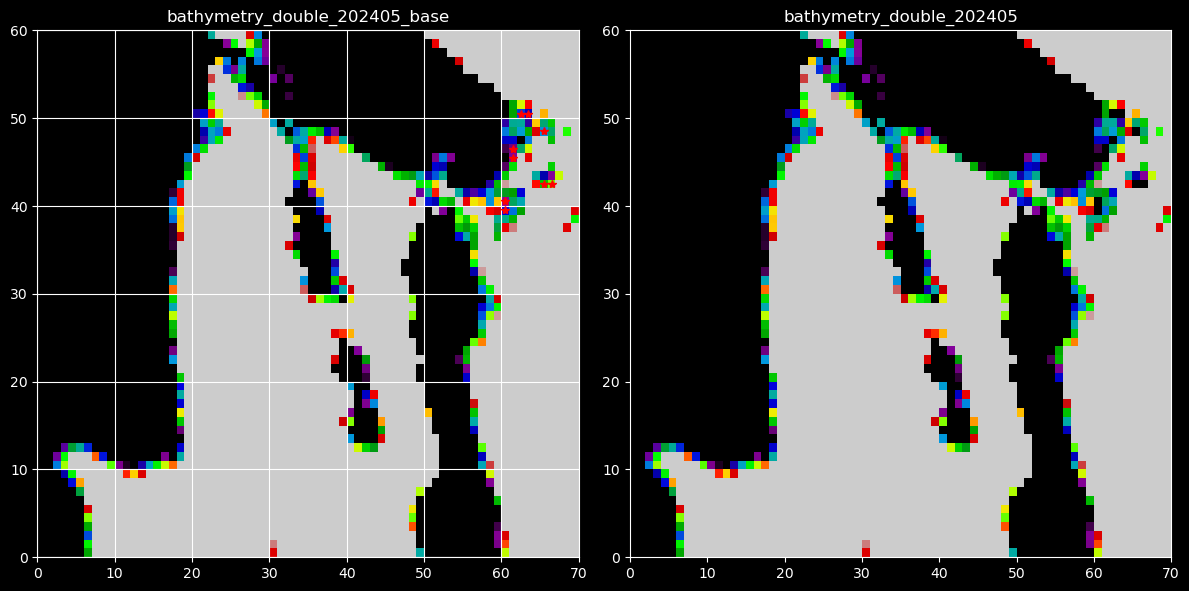

In [56]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([62, 50]),
    numpy.array([63, 50]),
    numpy.array([65, 48]),
    numpy.array([61, 46]),
    numpy.array([61, 45]),
    numpy.array([65, 42]),
    numpy.array([66, 42]),
    numpy.array([60, 40]),
    numpy.array([60, 39]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 14, 10 - Lulu Island and Point Grey

* connect Fraser River North Arm spit

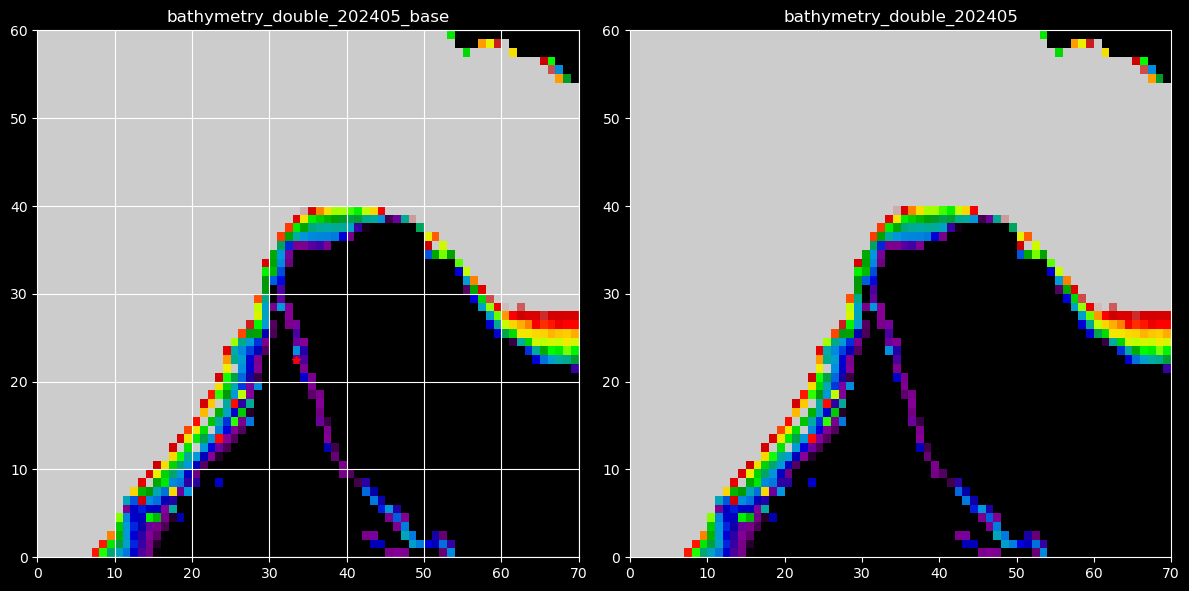

In [57]:
x_min_max = tile_x_min_max[10]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([33, 22]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 15 - Klanawa River to Cypress Mountain

In [58]:
y_min_max = numpy.array([480, 510])
y_slice = slice(*y_min_max * 2)

#### Tile 15, 6 - Saysutshun (Newcastle Island)

* Fix Protection Island by extending it 1 pixel south and separating it's north end from Saysutshun

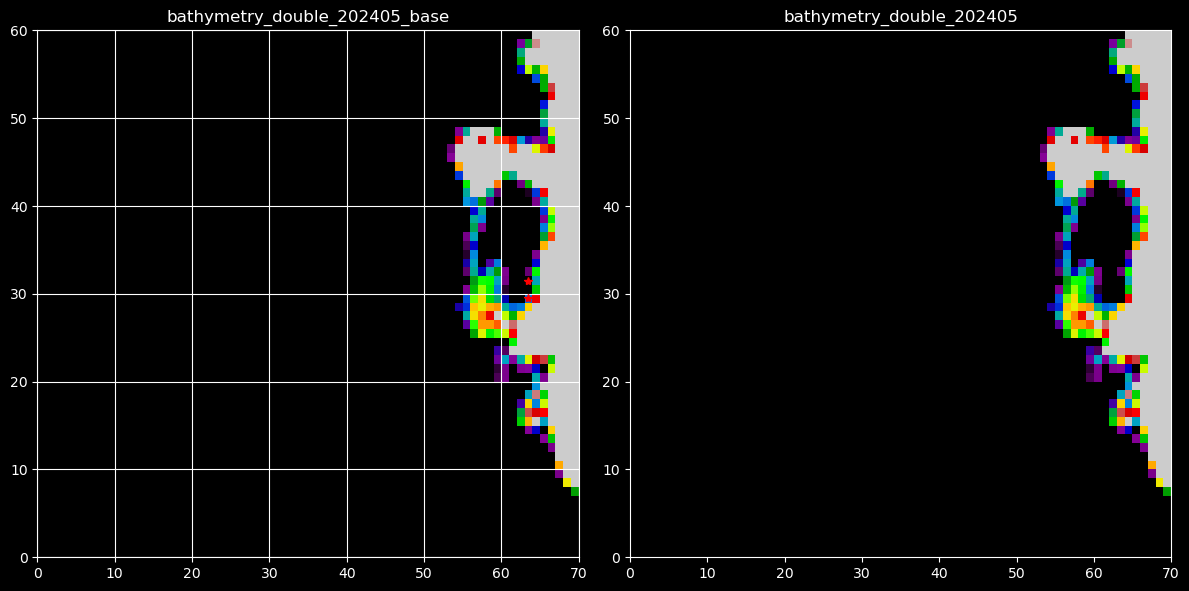

In [59]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([63, 29]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")
water_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([63, 31]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan
for water_pt in water_pts:
    adj = to_array_indices(water_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 15, 7 - Harmac, Dodds Narrows, Mudge Island, North Gabriola Island

* Improve Duke Point

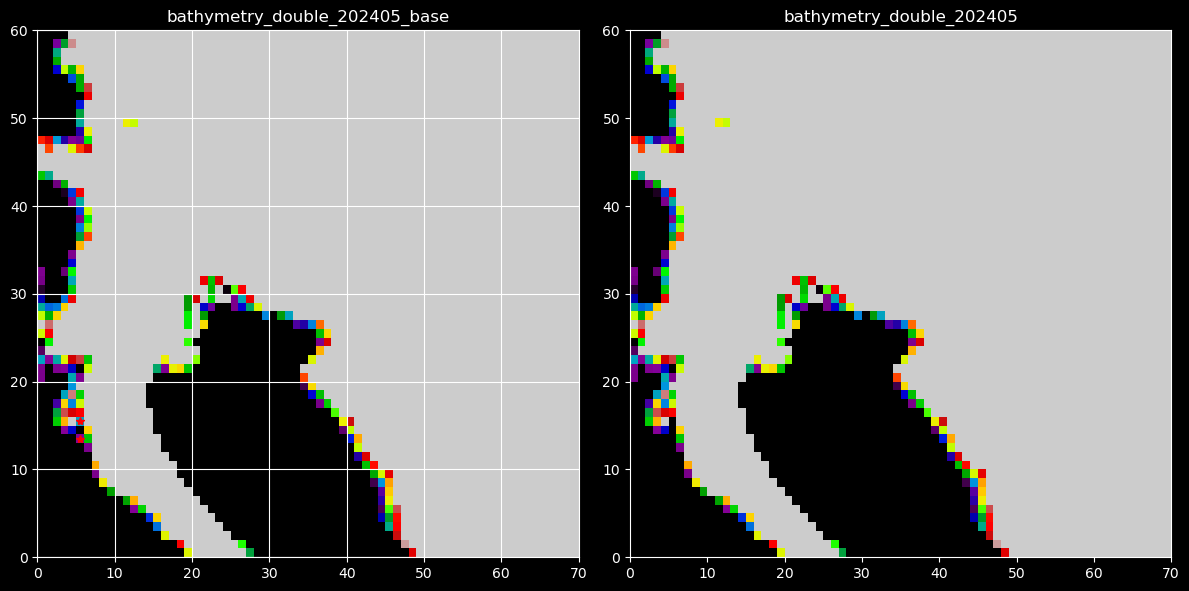

In [60]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([5, 13]),
    numpy.array([5, 15]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 15, 9 - Gospel Rock, West Keats Island

* check depth of dark pixel off Popham Island; remove if land

--
14.53090909090909
8.542424242424243
14.944444444444445
20.63504984113905
7.034666666666666
7.034666666666666
32.0
16.358051948051948
15.135026612537763


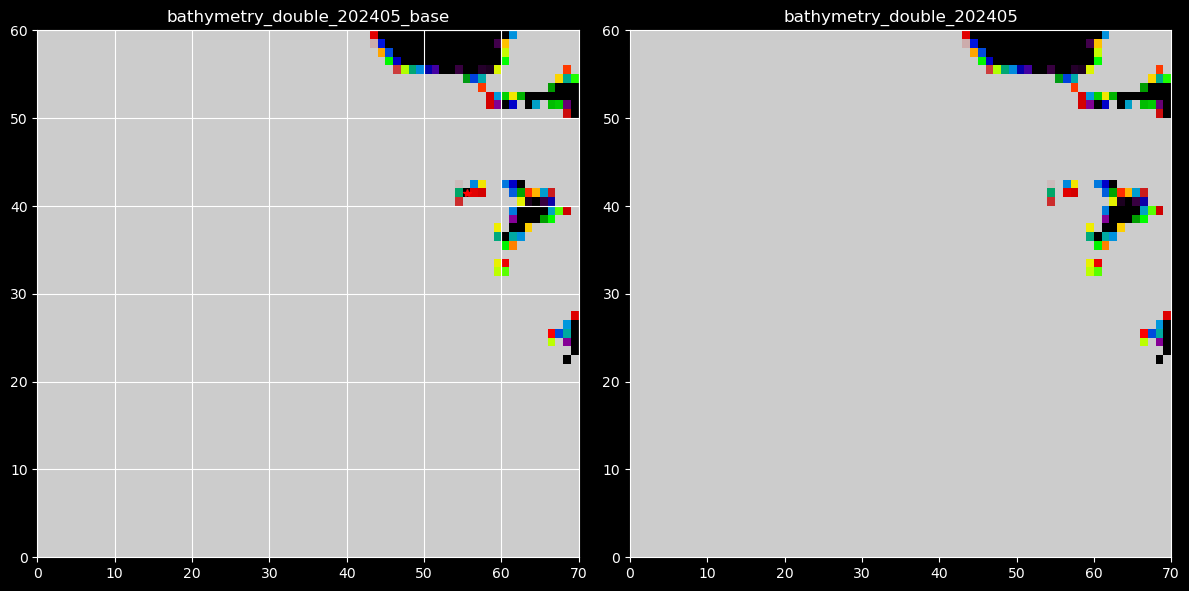

In [61]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
water_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([55, 41]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")

# land point that should be water off Popham Island
adj_pt = numpy.array([55, 41])
adj = to_array_indices(water_pt, y_min_max, x_min_max)
print(adj_bathy[adj])
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([54, 40]),
    numpy.array([54, 41]),
    numpy.array([54, 42]),
    numpy.array([56, 40]),
    numpy.array([56, 42]),
    numpy.array([56, 42]),
    numpy.array([55, 40]),
    numpy.array([55, 42]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(water_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 16 - Nanoose Bay to Howe Sound

In [62]:
y_min_max = numpy.array([510, 540])
y_slice = slice(*y_min_max * 2)

#### Tile 16, 6  - Nanoose Bay

* surface Southey Island
* surface Ruth Island
* surface Winchelsea Islands
* surface Yeo Islands

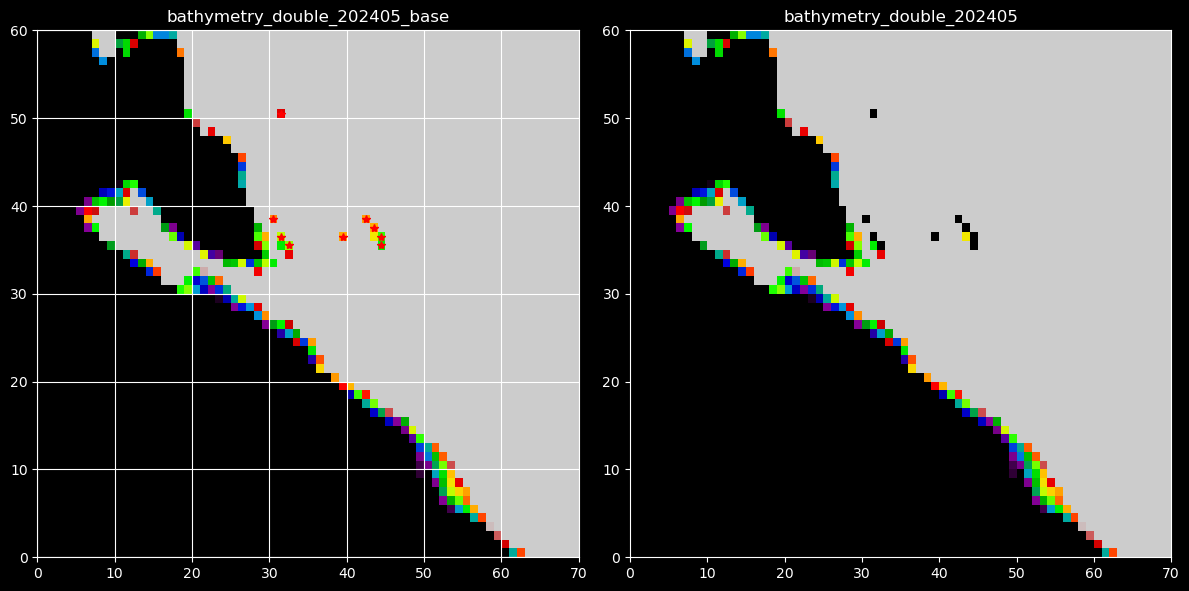

In [63]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    # Southey Island
    numpy.array([32, 35]),
    numpy.array([31, 36]),
    # Ruth Island
    numpy.array([30, 38]),
    # Winchelsea Islands
    numpy.array([39, 36]),
    numpy.array([42, 38]),
    numpy.array([43, 37]),
    numpy.array([44, 36]),
    numpy.array([44, 35]),
    # Yeo Islands
    numpy.array([31, 50]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 16, 10 - Gambier Island

* remove fake islet off the end of the 3rd peninsula

58.0
12.915707057330568
45.57150575777477
14.0
5.0
32.071526870919136
28.0
38.669840354195124
29.27857250502745


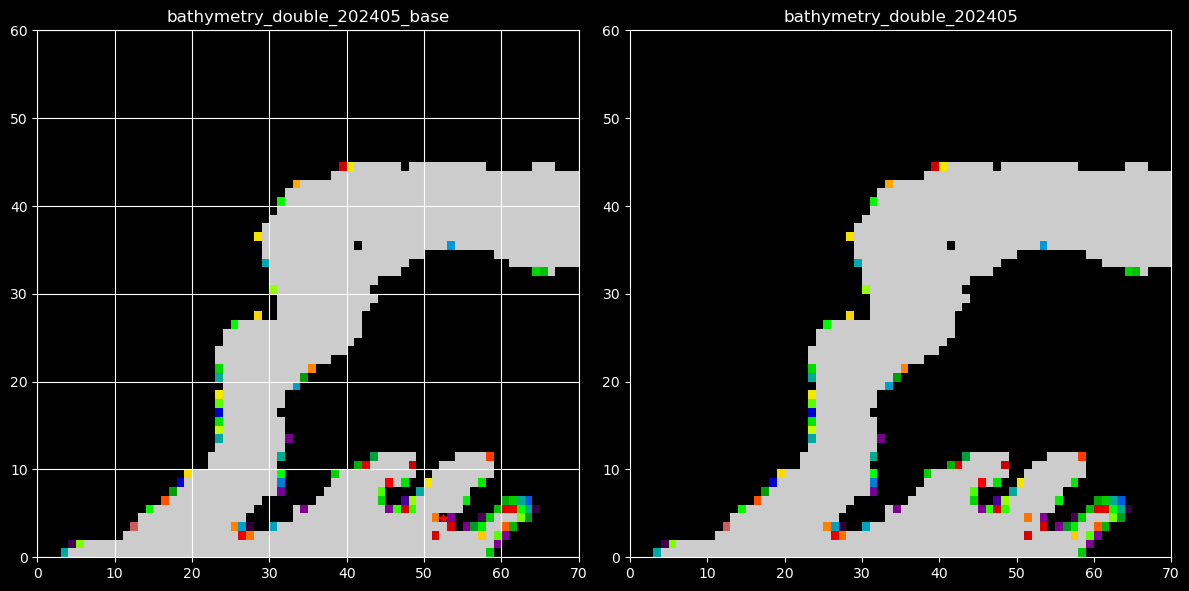

In [64]:
x_min_max = tile_x_min_max[10]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
water_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([52, 4]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")
near_pts = [  # grid cell x-y of cells surrounding cell to be adjusted
    numpy.array([51, 3]),
    numpy.array([51, 4]),
    numpy.array([51, 5]),
    numpy.array([53, 3]),
    numpy.array([53, 4]),
    numpy.array([53, 5]),
    numpy.array([52, 3]),
    numpy.array([52, 5]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)
adj = to_array_indices(water_pt, y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 17 - Parksville to Squamish Estuary

In [65]:
y_min_max = numpy.array([540, 570])
y_slice = slice(*y_min_max * 2)

#### Tile 17, 6 - Northwest Bay & Lasqueti Island

* connect Cottam Point
* surface Mistaken Island


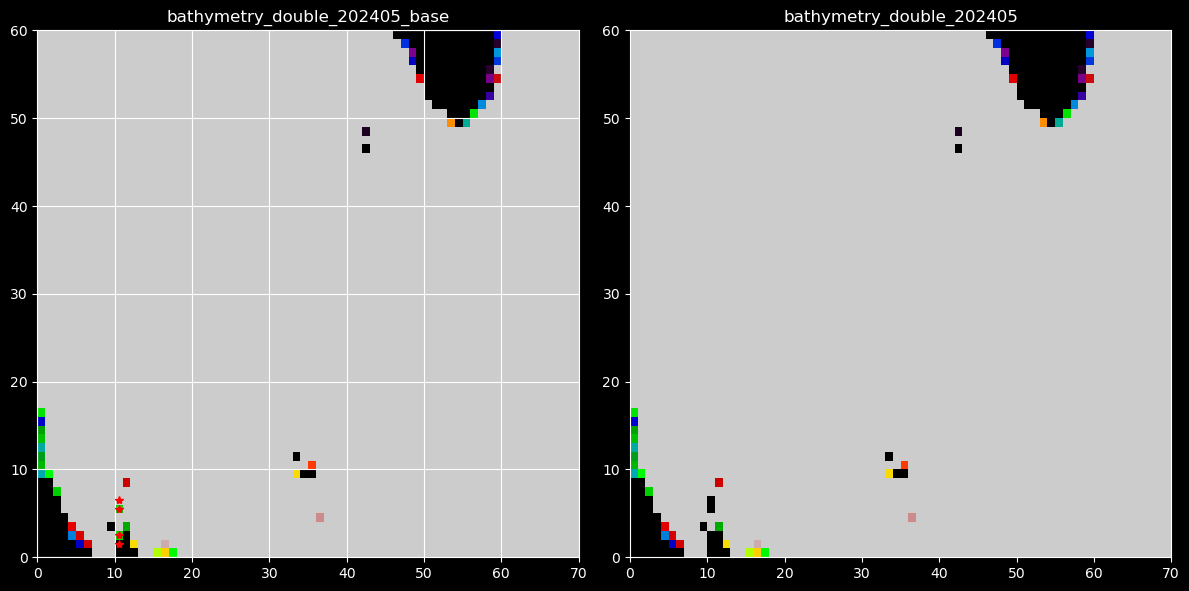

In [66]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    # Cottam Point
    numpy.array([10, 1]),
    numpy.array([10, 2]),
    # Mistaken Island
    numpy.array([10, 5]),
    numpy.array([10, 6]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 17, 7 - North & South Thormanby Islands

* remove fake islets off South Thormanby Island
* extend the north point of South Thormanby Island

* Although the northwest point of South Thormanby Island looks very different to how it appears on Google Maps,
  charts show that it is surrounded by <2m deep water.
  So, this representation is correct, given our 4m wall at the 2m isobath shoreline.


In [67]:
def calc_water_pt_depth(near_pts, adj_bathy):
    depth_sum = 0
    for near_pt in near_pts:
        adj = to_array_indices(near_pt, y_min_max, x_min_max)
        print(adj_bathy[adj])
        depth_sum += adj_bathy[adj]
    depth_mean = depth_sum / len(near_pts)
    print(f"  {depth_mean=}")
    return depth_mean


34.14180850982666
19.65833107630412
41.77777862548828
42.0
34.5
11.0
15.0
  depth_mean=28.296845458802725
98.23610941569011
93.37610880533855
96.56666310628255
52.30923207600912
38.29128392537435
29.0
47.0
31.0
  depth_mean=60.72242466608683


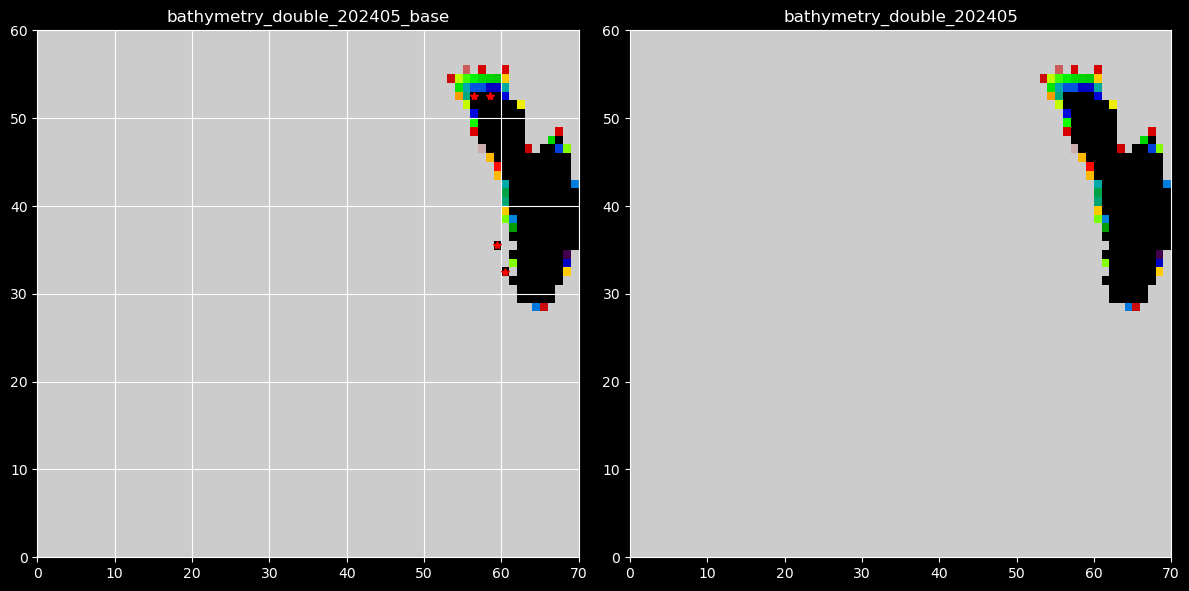

In [68]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
water_pts = [  # grid cell x-y to adjust in plot coordinates
    # Fake islets off South Thormanby IslandPoint
    numpy.array([60, 32]),
    numpy.array([59, 35]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")
land_pts = [
    # Extend the north point of South Thormanby Island
    numpy.array([56, 52]),
    numpy.array([58, 52]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
# Extend the north point of South Thormanby Island
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

# Fake islets off South Thormanby IslandPoint
near_pts = [  # grid cell x-y of cells surrounding cell to be adjusted
    numpy.array([59, 33]),
    numpy.array([59, 32]),
    numpy.array([59, 31]),
    numpy.array([60, 33]),
    numpy.array([60, 31]),
    numpy.array([61, 33]),
    numpy.array([61, 32]),
    # numpy.array([61, 31]),  # land
]
depth_mean = calc_water_pt_depth(near_pts, adj_bathy)
adj = to_array_indices(water_pts[0], y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

near_pts = [  # grid cell x-y of cells surrounding cell to be adjusted
    numpy.array([58, 36]),
    numpy.array([58, 35]),
    numpy.array([58, 34]),
    numpy.array([59, 36]),
    numpy.array([59, 34]),
    numpy.array([60, 36]),
    numpy.array([60, 35]),
    numpy.array([60, 34]),
]
depth_mean = calc_water_pt_depth(near_pts, adj_bathy)
adj = to_array_indices(water_pts[1], y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 17, 8 - Sechelt to Secret Cove

* flatten east side of Welcome Passage and make passage ~2 grid cells wide
* surface Merry Island
* surface Trail Islands
* dig out Sargeant Bay to be 2x2

In [69]:
y_min_max = numpy.array([530, 570])
y_slice = slice(*y_min_max * 2)

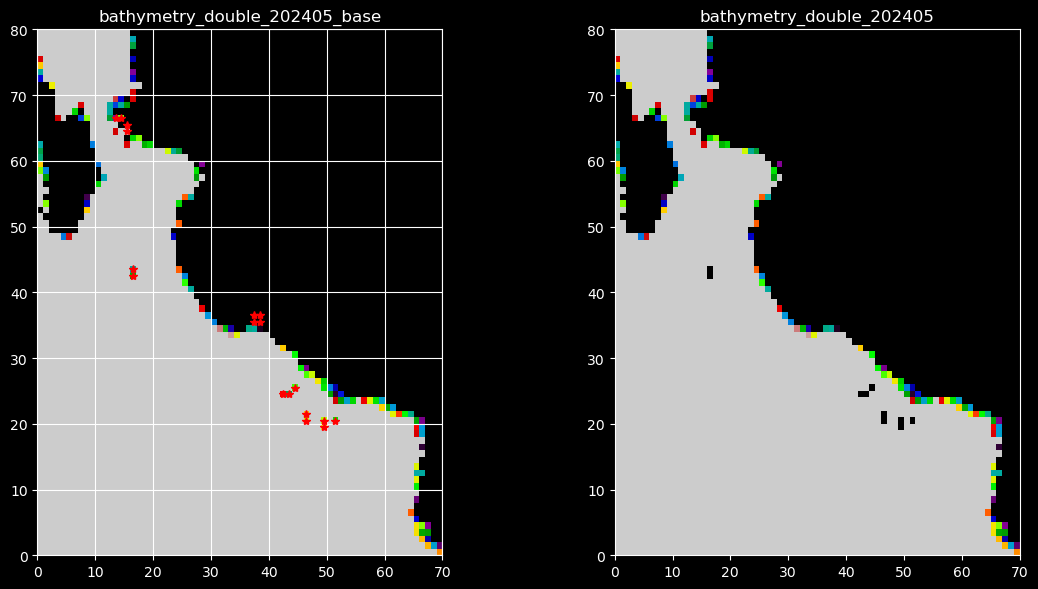

In [70]:
x_min_max = tile_x_min_max[8]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [
    # Flatten east side of Welcome Passage and make passage ~2 grid cells wide
    numpy.array([13, 66]),
    numpy.array([14, 66]),
    numpy.array([15, 65]),
    numpy.array([15, 64]),
    # Merry Island
    numpy.array([16, 42]),
    numpy.array([16, 43]),
    # Trail Islands
    numpy.array([42, 24]),
    numpy.array([43, 24]),
    numpy.array([44, 25]),
    numpy.array([46, 21]),
    numpy.array([46, 20]),
    numpy.array([49, 20]),
    numpy.array([49, 19]),
    numpy.array([51, 20]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")
water_pts = [  # grid cell x-y to adjust in plot coordinates
    # Dig out Sargeant Bay to be 2x2
    numpy.array([38, 35]),
    numpy.array([38, 36]),
    numpy.array([37, 35]),
    numpy.array([37, 36]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")

# Do the adjustments
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan
for water_pt in water_pts:
    adj = to_array_indices(water_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 17, 12 - Squamish Estuary

* connect Squamish townsite point

In [71]:
y_min_max = numpy.array([540, 570])
y_slice = slice(*y_min_max * 2)

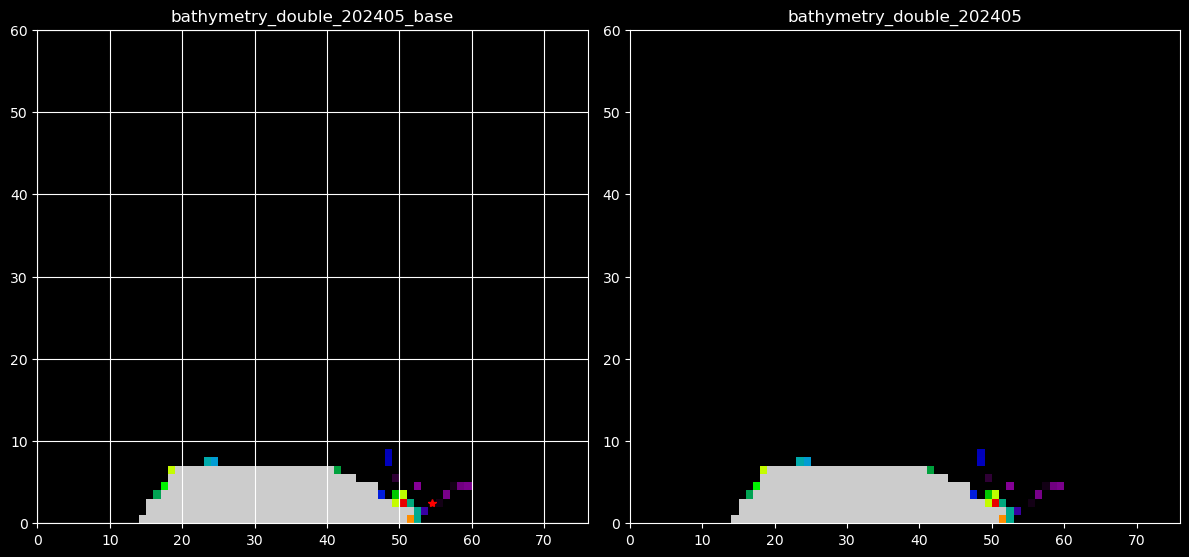

In [72]:
x_min_max = tile_x_min_max[12]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [
    numpy.array([54, 2]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 18 - Qualicum Beach to Pender Harbour

In [73]:
y_min_max = numpy.array([570, 600])
y_slice = slice(*y_min_max * 2)

#### Tile 18, 5 - NW Lasqueti Island

Plotted with `vmax=80` to make Sisters Islets visible.

* surface Sisters Islets

water_pt=array([47, 42]) depth=74.5311050415039
water_pt=array([48, 42]) depth=71.32400512695312
water_pt=array([48, 43]) depth=76.46963500976562


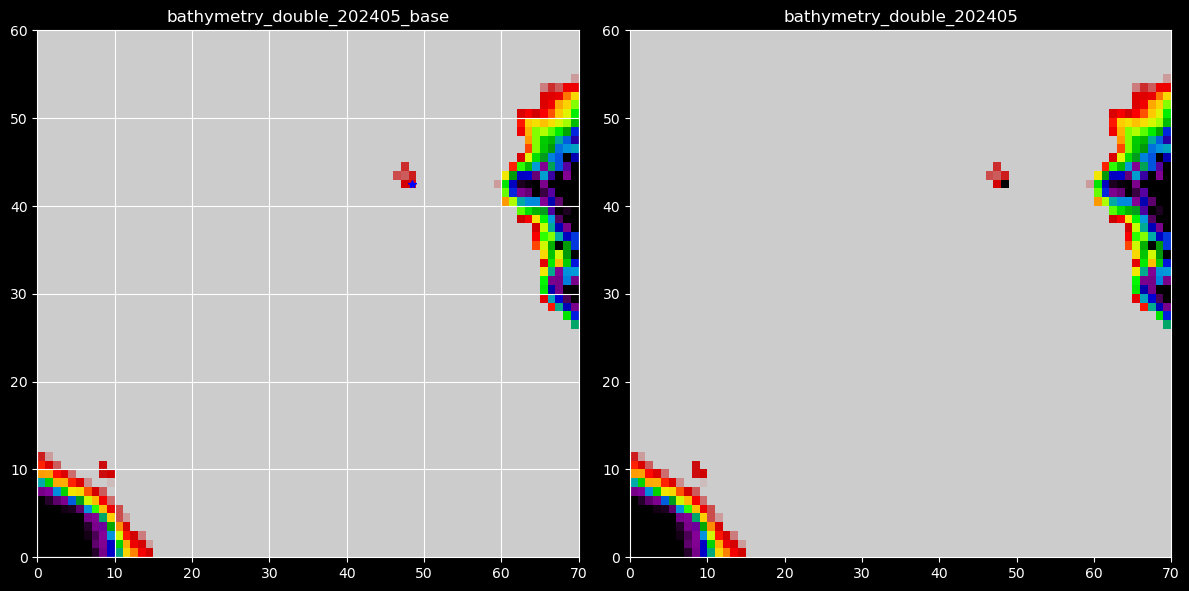

In [74]:
x_min_max = tile_x_min_max[5]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=80)
ax_base.grid(True)

# Depths of possible Sisters Islets grid point
water_pts = [
    numpy.array([47, 42]),
    numpy.array([48, 42]),
    numpy.array([48, 43]),
]
for water_pt in water_pts:
    adj = to_array_indices(water_pt, y_min_max, x_min_max)
    print(f"{water_pt=} depth={adj_bathy[adj]}")
# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    # Shallowest grid point for Sisters Islets
    numpy.array([48, 42]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "b*")

# Do the adjustment
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=80)

fig.tight_layout()

#### Tile 18, 6 - Lasqueti, Jervis, Jedediah & Texada Islands

* remove fake island in the mouth of False Bay
* connect fake islands as points on Jedediah Island

52.09444046020508
40.64996655782064
43.08947499593099
31.233330408732098
55.0
17.272523880004883
38.0
38.0
  depth_mean=39.417467037836715


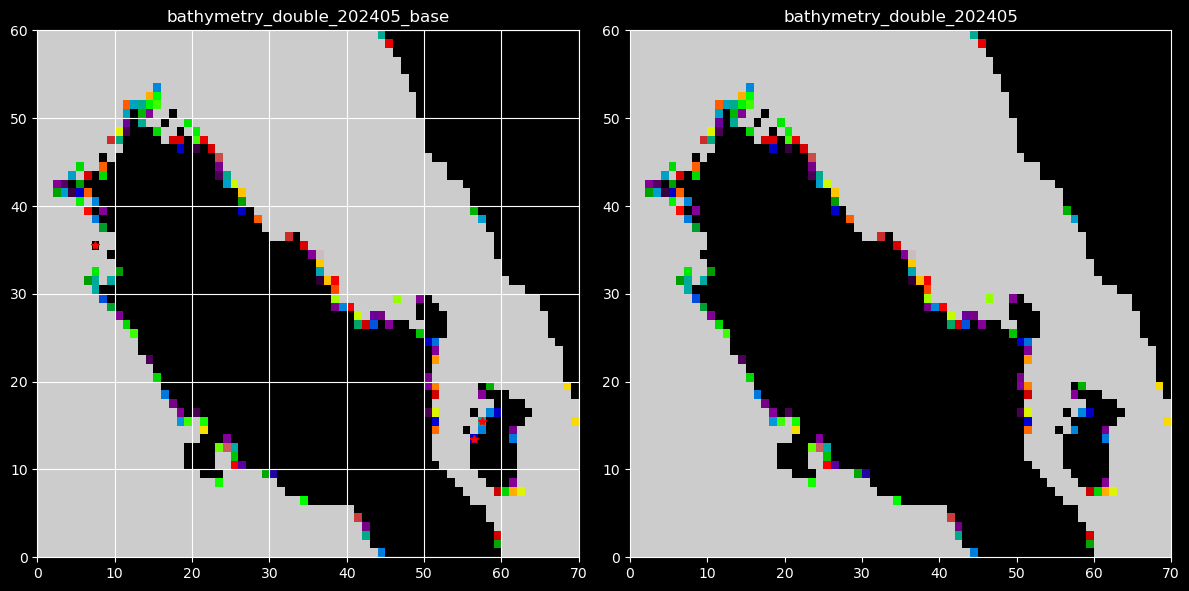

In [75]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
water_pts = [  # grid cell x-y to adjust in plot coordinates
    # Fake islets in the mouth of False Bay
    numpy.array([7, 35]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")
land_pts = [
    # Connect fake islands as points on Jedediah Island
    numpy.array([57, 15]),
    numpy.array([56, 13]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
# Connect fake islands as points on Jedediah Island
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan
#
# Fake islets in the mouth of False Bay
near_pts = [  # grid cell x-y of cells surrounding cell to be adjusted
    numpy.array([6, 36]),
    numpy.array([6, 35]),
    numpy.array([6, 34]),
    numpy.array([7, 36]),
    numpy.array([7, 34]),
    numpy.array([8, 36]),
    numpy.array([8, 35]),
    numpy.array([8, 34]),
]
depth_mean = calc_water_pt_depth(near_pts, adj_bathy)
adj = to_array_indices(water_pts[0], y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 19 - Fanny Bay to Jervis Inlet

In [76]:
y_min_max = numpy.array([600, 630])
y_slice = slice(*y_min_max * 2)

#### Tile 19, 7 - Hardy Island & Nelson Island

* Remove fake islet off Hardy Island


114.01451110839844
86.82445398966472
44.74722544352213
91.38703791300456
63.5
50.807939529418945
85.0
13.0
  depth_mean=68.6601459980011


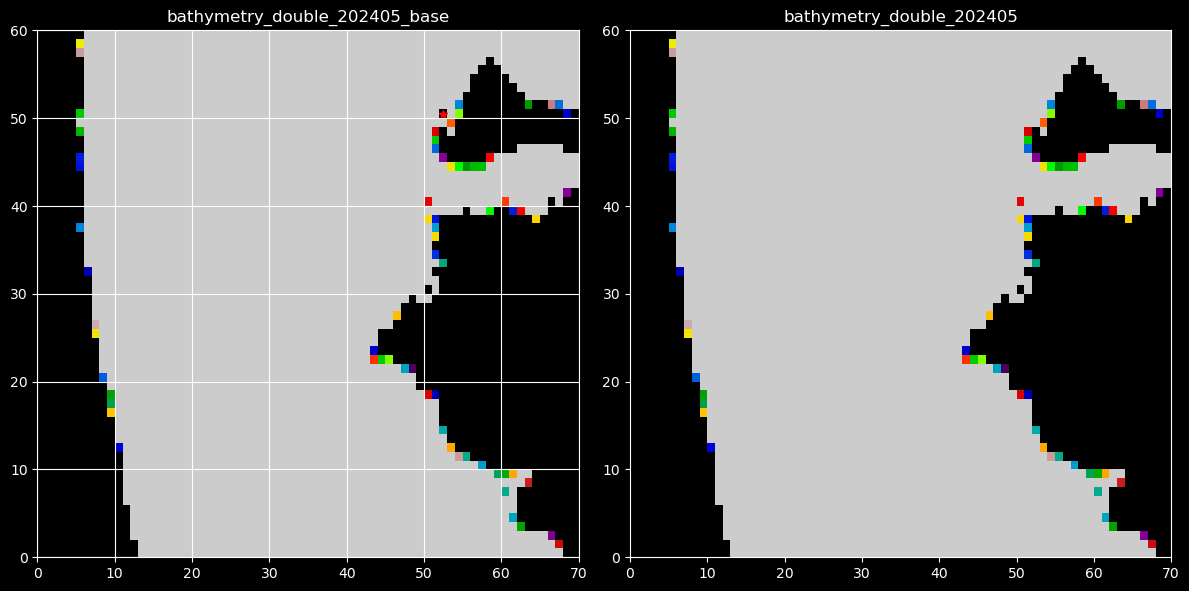

In [77]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
water_pts = [  # grid cell x-y to adjust in plot coordinates
    # Shallowest grid point for Sisters Islets
    numpy.array([52, 50]),
]
for water_pt in water_pts:
    ax_base.plot(*water_pt+0.5, "r*")

# # Do the adjustment
near_pts = [  # grid cell x-y of cells surrounding cell to be adjusted
    numpy.array([51, 51]),
    numpy.array([51, 50]),
    numpy.array([51, 49]),
    numpy.array([52, 51]),
    numpy.array([52, 49]),
    numpy.array([53, 51]),
    numpy.array([53, 50]),
    numpy.array([53, 49]),
]
depth_mean = calc_water_pt_depth(near_pts, adj_bathy)
adj = to_array_indices(water_pts[0], y_min_max, x_min_max)
adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 20 - Union Bay to Jervis Inlet

In [78]:
y_min_max = numpy.array([630, 660])
y_slice = slice(*y_min_max * 2)

#### Tile 20, 4 - Morning Beach

* connect islet off the west side of the Denman Island tip by making purple cell to the north-east land


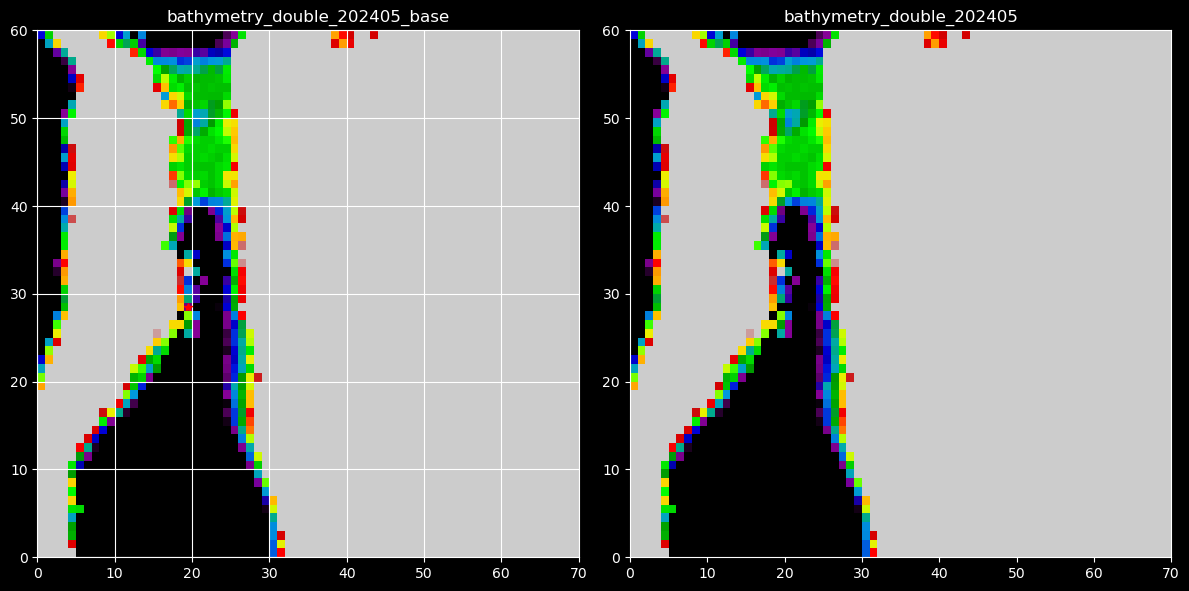

In [79]:
x_min_max = tile_x_min_max[4]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [
    # Connect fake islet as point on west side of Denman Island tip
    numpy.array([19, 28]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 20, 7 - Lang Bay

* Surface McRae Islet

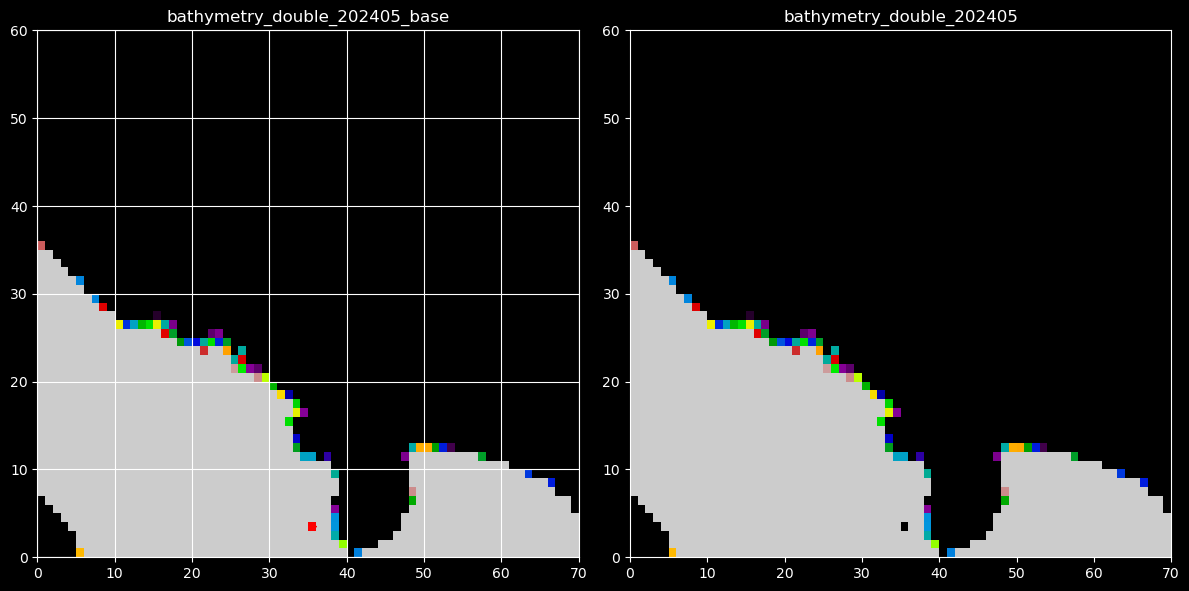

In [80]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark the adjustment
land_pts = [  # grid cell x-y to adjust in plot coordinates
    # McRae Islet
    numpy.array([35, 3]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 20, 8 - Jervis Inlet

* Surface Skyes Island (2 green cells)

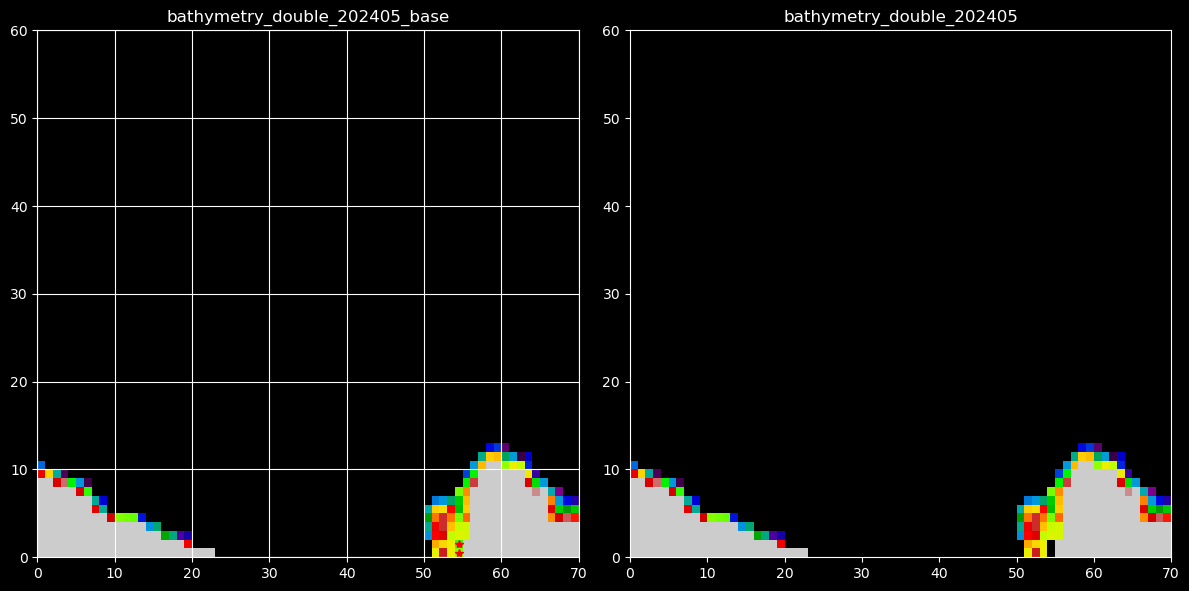

In [81]:
x_min_max = tile_x_min_max[8]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=80)
ax_base.grid(True)

# Mark the adjustment
land_pts = [
    # Connect fake islet as point on west side of Denman Island tip
    numpy.array([54, 0]),
    numpy.array([54, 1]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=80)

fig.tight_layout()

#### Tile 20, 9 - Jervis Inlet

* add land cell to make point in head of western inlet


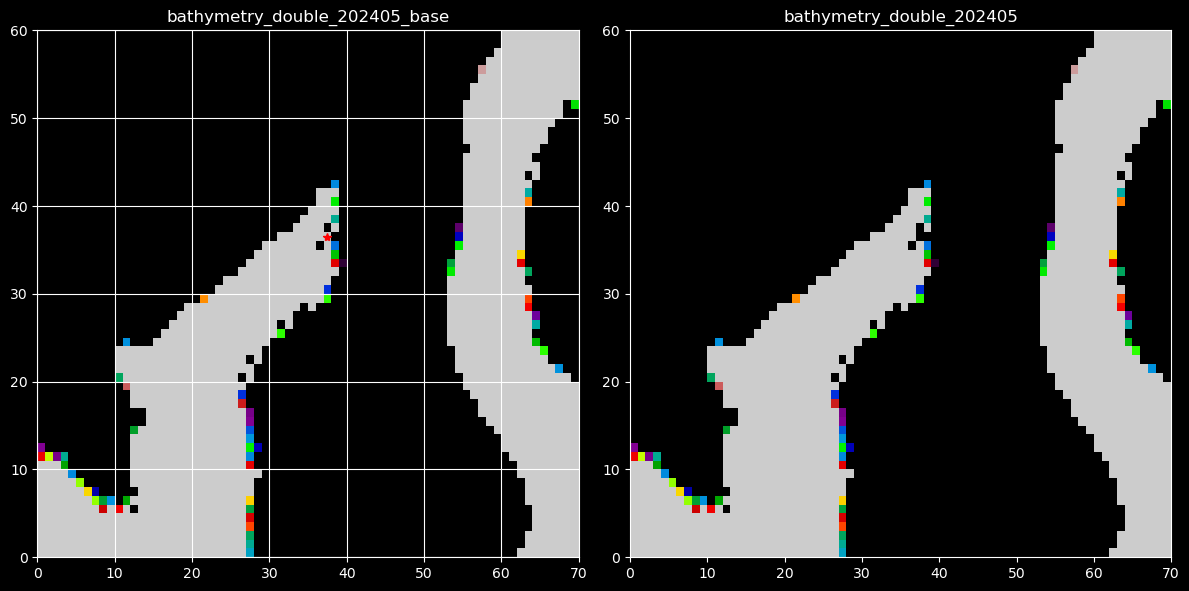

In [82]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=40)
ax_base.grid(True)

# Mark the adjustment
land_pts = [
    # Connect fake islet as point on west side of Denman Island tip
    numpy.array([37, 36]),
]
for land_pt in land_pts:
    ax_base.plot(*land_pt+0.5, "r*")

# Do the adjustments
for land_pt in land_pts:
    adj = to_array_indices(land_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=40)

fig.tight_layout()

**IMPORTANT:** Don't smooth bathymetry until after adjustments are finished.

## Smooth the Bathymetry

In [49]:
sm_bathy = bathy_tools.smooth(adj_bathy, max_norm_depth_diff=0.8, smooth_factor=0.2)

In [50]:
depth_check(sm_bathy)

## Store Finished Bathymetry in a netCDF File

We now have the finished bathymetry.
Store it in a netCDF file.

**IMPORTANT:** Ensure that correct bathymetry array is stored. Use `adj_bathy` during adjustment processing. Use `sm_bathy` after adjusted bathymetry has been smoothed.

In [83]:
final_bathy = adj_bathy

In [84]:
final_dbl_202405_ds = xarray.Dataset(
    data_vars={
        "Bathymetry": xarray.DataArray(
            data=final_bathy,
            dims=["y", "x"],
            attrs={
                "long_name": "sea_floor_depth",
                "units": "m",
            },
        ),
        "nav_lat": xarray.DataArray(
            data=lats,
            dims=["y", "x"],
            attrs={
                "long_name": "latitude",
                "units": "degrees_north",
            },
        ),
        "nav_lon": xarray.DataArray(
            data=lons,
            dims=["y", "x"],
            attrs={
                "long_name": "longitude",
                "units": "degrees_east",
            },
        ),
    },
    coords={
        "y": numpy.arange(final_bathy.shape[0], dtype=int),
        "x": numpy.arange(final_bathy.shape[1], dtype=int),
    },
    attrs={
        "Conventions": "CF-1.6",
        "title": "Bathymetry 202405 Double Resolution",
        "institution": "Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia",
        "source": "Bathymetry processed from analysis-doug/notebooks/2xrez-202111/bathymetry-202405-2xrez.ipynb "
                  "by tools/bathymetry/Process202405-2xrezBathymetry.ipynb",
        "history": f"[{arrow.now():YYYY-MM-DD HH:mm:ss}] Created netCDF4 zlib=True dataset.",
    },
)

final_dbl_202405_ds

<xarray.Dataset> Size: 35MB
Dimensions:     (y: 1816, x: 796)
Coordinates:
  * y           (y) int64 15kB 0 1 2 3 4 5 6 ... 1810 1811 1812 1813 1814 1815
  * x           (x) int64 6kB 0 1 2 3 4 5 6 7 ... 789 790 791 792 793 794 795
Data variables:
    Bathymetry  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan nan
    nav_lat     (y, x) float64 12MB 46.84 46.83 46.83 ... 51.11 51.11 51.11
    nav_lon     (y, x) float64 12MB -123.4 -123.4 -123.4 ... -124.3 -124.3
Attributes:
    Conventions:  CF-1.6
    title:        Bathymetry 202405 Double Resolution
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       Bathymetry processed from analysis-doug/notebooks/2xrez-202...
    history:      [2026-01-16 12:14:20] Created netCDF4 zlib=True dataset.

In [85]:
encoding = {
    "Bathymetry": {"zlib": True, "complevel": 4},
    "nav_lat": {"zlib": True, "complevel": 4},
    "nav_lon": {"zlib": True, "complevel": 4},
}
# use `engine="netcdf4"` because it produces a substantially smaller file than `engine="h5netcdf"`
final_dbl_202405_ds.to_netcdf(bathy_paths["dbl_final_202405"], encoding=encoding, engine="netcdf4")